<a id="inicio-notebook"></a>
# Proyecto End to End de Machine Learning 
### Viviendas en venta en Madrid


## 0. Librerías
 

In [1]:
# importación agrupada de librerías necesarias en este notebook
import pandas as pd
from pandas import StringDtype
import numpy as np
import json
import re

import sys
import os
from datetime import date

from scipy import stats
from scipy.stats import chi2_contingency
from PIL import Image
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, LabelBinarizer, MultiLabelBinarizer, OneHotEncoder 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

#warnings.filterwarnings('ignore')

# Añado el directorio padre (del que está este notebook) a sys.path
sys.path.append(os.path.abspath('../'))
from scripts.utils_agv import ini_inspec, crear_tabla_resumen, categoricas, numericas

<a id="comprension-variables"></a>
## 4. Compresión de variables

In [2]:
# carga de los datos guardados en el anterior paso
df = pd.read_csv('../data/processed/ide_viv_limpieza0_2025-03-11.csv', index_col='propertyCode')

In [3]:
df.index.name = 'ID'
# Mover la columna 'price' a la primera posición
columnas = ['price'] + [col for col in df.columns if col != 'price']
df = df.reindex(columns=columnas)
print (df.shape)
df.head(1)

(1747, 24)


price  numPhotos floor propertyType   size exterior  rooms  \
ID                                                                          
107526421  1095000.0         43     3         flat  146.0     True      3   

           bathrooms               address district  ... hasVideo  status  \
ID                                                   ...                    
107526421          2  calle de las Fuentes   Centro  ...     True    good   

           hasLift priceByArea          detailedType  \
ID                                                     
107526421     True      7500.0  {'typology': 'flat'}   

                                              suggestedTexts hasPlan  \
ID                                                                     
107526421  {'subtitle': 'Sol, Madrid', 'title': 'Piso en ...    True   

           has3DTour has360 topPlus  
ID                                   
107526421       True  False    True  

[1 rows x 24 columns]

In [4]:
ini_inspec(df)

=== TAMAÑO Y ESTRUCTURA DE LOS DATOS ===
Número total de registros (filas): 1747
Número de columnas: 24
Uso de memoria: 281.50 KB


=== TIPOS DE DATOS Y NOMBRES DE COLUMNAS ===
price             float64
numPhotos           int64
floor              object
propertyType       object
size              float64
exterior           object
rooms               int64
bathrooms           int64
address            object
district           object
neighborhood       object
latitude          float64
longitude         float64
description        object
hasVideo             bool
status             object
hasLift            object
priceByArea       float64
detailedType       object
suggestedTexts     object
hasPlan              bool
has3DTour            bool
has360               bool
topPlus              bool
dtype: object


Información detallada del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 1747 entries, 107526421 to 107518858
Data columns (total 24 columns):
 #   Column          Non-Null C

Después de esta primera inspección, confirmado que no hay duplicados, vamos a abordar los problemas que observo: valores faltantes, contenidos como diccionario.

### Tratamiento (desdoblado) de las columnas cuyos valores son diccionarios

In [5]:
df['detailedType'].unique()

array(["{'typology': 'flat'}",
       "{'typology': 'flat', 'subTypology': 'studio'}",
       "{'typology': 'flat', 'subTypology': 'penthouse'}",
       "{'typology': 'flat', 'subTypology': 'duplex'}"], dtype=object)

In [6]:
df['suggestedTexts'].unique()

array(["{'subtitle': 'Sol, Madrid', 'title': 'Piso en calle de las Fuentes'}",
       "{'subtitle': 'Malasaña-Universidad, Madrid', 'title': 'Piso en calle del Divino Pastor'}",
       "{'subtitle': 'Lavapiés-Embajadores, Madrid', 'title': 'Piso'}",
       "{'subtitle': 'Sol, Madrid', 'title': 'Piso en Carrera de San Jerónimo'}",
       "{'subtitle': 'Malasaña-Universidad, Madrid', 'title': 'Estudio en calle de San Andrés'}",
       "{'subtitle': 'Malasaña-Universidad, Madrid', 'title': 'Ático en calle de Fuencarral'}",
       "{'subtitle': 'Malasaña-Universidad, Madrid', 'title': 'Piso en calle de Fuencarral'}",
       "{'subtitle': 'Palacio, Madrid', 'title': 'Dúplex en calle de Santiago'}",
       "{'subtitle': 'Chueca-Justicia, Madrid', 'title': 'Piso en calle de Apodaca'}",
       "{'subtitle': 'Sol, Madrid', 'title': 'Piso'}",
       "{'subtitle': 'Malasaña-Universidad, Madrid', 'title': 'Piso en calle del Espíritu Santo'}",
       "{'subtitle': 'Malasaña-Universidad, Madrid', 't

Voy a separar en columnas aquellas cuyos datos son dicionarios:


In [7]:
#FUNCIÓN PARA EXPANDIR CELDAS CON CONTENIDO DICCIONARIOS
def expand_dict_columns(df):
    """
    Expande las columnas del dataframe de Idealista que contienen diccionarios.
    
    Parámetros:
    df (pandas.DataFrame): DataFrame con datos de Idealista
    
    Retorna:
    pandas.DataFrame: DataFrame con las columnas expandidas
    """
    # Hacer una copia del dataframe original para no modificarlo
    df_processed = df.copy()
    
    def parse_dict_safely(value):
        """Convierte strings a diccionarios de forma segura sin usar ast"""
        if pd.isna(value):
            return {}
        if isinstance(value, dict):
            return value
        if isinstance(value, str) and value.strip():
            try:
                # Intentar convertir usando json.loads
                return json.loads(value)
            except json.JSONDecodeError:
                try:
                    # Si falla, corregimos comillas simples a dobles
                    value = value.replace("'", "\"")
                    return json.loads(value)
                except json.JSONDecodeError:
                    # Si aún falla, retornar vacío
                    return {}
        return {}
    
    def process_column(column_name, field_mappings):
        """
        Procesa una columna de diccionario y extrae campos específicos.
        
        Parámetros:
        column_name (str): Nombre de la columna a procesar
        field_mappings (dict): Diccionario donde la clave es el nombre del campo 
                               a extraer y el valor es un valor por defecto
        """
        if column_name not in df_processed.columns:
            return
            
        # Convertir strings a diccionarios
        df_processed[column_name] = df_processed[column_name].apply(parse_dict_safely)
        
        # Extraer cada campo del diccionario
        for field, default_value in field_mappings.items():
            new_column_name = f"{column_name}_{field}"
            df_processed[new_column_name] = df_processed[column_name].apply(
                lambda x: x.get(field, default_value) if isinstance(x, dict) else default_value
            )
    
    # Definir los campos a extraer para cada columna
    column_fields = {
        'suggestedTexts': {'subtitle': None, 'title': None},
        'detailedType': {'typology': None, 'subTypology': None},
        'parkingSpace': {
            'hasParkingSpace': False, 
            'isParkingSpaceIncludedInPrice': None,
            'parkingSpacePrice': None
        }
    }
    
    # Procesar cada columna
    for column, fields in column_fields.items():
        process_column(column, fields)
    
    # Eliminar las columnas originales
    columns_to_drop = [col for col in column_fields.keys() if col in df_processed.columns]
    df_processed = df_processed.drop(columns=columns_to_drop)
    
    return df_processed

In [8]:
# CELDA SALTADA intento de tratamiento de todas las columnas con diccionarios, incluso Parking
pass
def expand_dict_columns2(df):
    """
    Expande las columnas del dataframe de Idealista que contienen diccionarios.
    
    Parámetros:
    df (pandas.DataFrame): DataFrame con datos de Idealista
    
    Retorna:
    pandas.DataFrame: DataFrame con las columnas expandidas
    """
    # Hacer una copia del dataframe original para no modificarlo
    df_processed = df.copy()
    
    def parse_dict_safely(value):
        """Convierte strings a diccionarios de forma segura sin usar ast"""
        if pd.isna(value):
            return {}
        if isinstance(value, dict):
            return value
        if isinstance(value, str) and value.strip():
            try:
                # Intentar convertir usando json.loads
                return json.loads(value)
            except json.JSONDecodeError:
                try:
                    # Si falla, corregimos comillas simples a dobles
                    value = value.replace("'", "\"")
                    return json.loads(value)
                except json.JSONDecodeError:
                    # Si aún falla, retornar vacío
                    return {}
        return {}
    
    # Procesar columna suggestedTexts
    if 'suggestedTexts' in df_processed.columns:
        df_processed['suggestedTexts'] = df_processed['suggestedTexts'].apply(parse_dict_safely)
        df_processed['suggestedTexts_subtitle'] = df_processed['suggestedTexts'].apply(
            lambda x: x.get('subtitle') if isinstance(x, dict) else None
        )
        df_processed['suggestedTexts_title'] = df_processed['suggestedTexts'].apply(
            lambda x: x.get('title') if isinstance(x, dict) else None
        )
    
    # Procesar columna detailedType
    if 'detailedType' in df_processed.columns:
        df_processed['detailedType'] = df_processed['detailedType'].apply(parse_dict_safely)
        df_processed['detailedType_typology'] = df_processed['detailedType'].apply(
            lambda x: x.get('typology') if isinstance(x, dict) else None
        )
        df_processed['detailedType_subTypology'] = df_processed['detailedType'].apply(
            lambda x: x.get('subTypology') if isinstance(x, dict) else None
        )
    
    # Procesar columna parkingSpace - Esto lo dejamos explícito para manejar mejor los casos especiales
    if 'parkingSpace' in df_processed.columns:
        # Convertir strings a diccionarios y manejar valores NaN
        df_processed['parkingSpace'] = df_processed['parkingSpace'].apply(parse_dict_safely)
        
        # Extraer hasParkingSpace - valor por defecto es False
        df_processed['parkingSpace_hasParkingSpace'] = df_processed['parkingSpace'].apply(
            lambda x: x.get('hasParkingSpace', False) if isinstance(x, dict) else False
        )
        
        # Extraer isParkingSpaceIncludedInPrice - Sin valor por defecto para preservar NaN cuando no existe
        df_processed['parkingSpace_isParkingSpaceIncludedInPrice'] = df_processed['parkingSpace'].apply(
            lambda x: x.get('isParkingSpaceIncludedInPrice') if isinstance(x, dict) else pd.NA
        )
        
        # Extraer parkingSpacePrice - Convertimos a float explícitamente si existe
        df_processed['parkingSpace_parkingSpacePrice'] = df_processed['parkingSpace'].apply(
            lambda x: float(x.get('parkingSpacePrice')) if isinstance(x, dict) and 'parkingSpacePrice' in x and x['parkingSpacePrice'] is not None else pd.NA
        )
    
    # Eliminar las columnas originales que contenían diccionarios
    columns_to_drop = []
    for col in ['suggestedTexts', 'detailedType', 'parkingSpace']:
        if col in df_processed.columns:
            columns_to_drop.append(col)
    
    df_processed = df_processed.drop(columns=columns_to_drop)
    return df_processed

In [9]:
# df_ampliado_dict = expand_dict_columns(df, dict_columns=['otraColumnaDict', 'segundaColumnaDict'])
df_ampliado_dict = expand_dict_columns(df)
df_ampliado_dict

price  numPhotos floor propertyType   size exterior  rooms  \
ID                                                                          
107526421  1095000.0         43     3         flat  146.0     True      3   
107246640  1195000.0         27     2         flat  134.0     True      3   
106773918   790000.0         33     3         flat  148.0     True      2   
102711209  2350000.0         44     5         flat  218.0     True      4   
106822977   235000.0         34    bj       studio   38.0    False      0   
...              ...        ...   ...          ...    ...      ...    ...   
107419060  4200000.0          0     3         flat  288.0     True      3   
106976644  2810000.0          0     1         flat  238.0     True      3   
107230033  2170000.0          0     4    penthouse  125.0     True      2   
106530192   999000.0          0     3         flat  160.0    False      4   
107518858   259000.0          0     2         flat   34.0    False      1   

           bathrooms                      address district  ... hasLift  \
ID                                                          ...           
107526421          2         calle de las Fuentes   Centro  ...    True   
107246640          3      calle del Divino Pastor   Centro  ...    True   
106773918          2  Barrio Lavapiés-Embajadores   Centro  ...    True   
102711209          4      Carrera de San Jerónimo   Centro  ...    True   
106822977          1          calle de San Andrés   Centro  ...    True   
...              ...                          ...      ...  ...     ...   
107419060          3          calle del Almirante   Centro  ...    True   
106976644          4                   Barrio Sol   Centro  ...    True   
107230033          3       Barrio Chueca-Justicia   Centro  ...    True   
106530192          2  Barrio Lavapiés-Embajadores   Centro  ...    True   
107518858          1  Barrio Malasaña-Universidad   Centro  ...   False   

           priceByArea  hasPlan has3DTour  has360 topPlus  \
ID                                                          
107526421       7500.0     True      True   False    True   
107246640       8918.0     True      True    True    True   
106773918       5338.0     True      True   False    True   
102711209      10780.0     True      True   False    True   
106822977       6184.0     True      True   False    True   
...                ...      ...       ...     ...     ...   
107419060      14583.0    False     False   False   False   
106976644      11807.0    False     False   False   False   
107230033      17360.0    False     False   False   False   
106530192       6244.0    False     False   False   False   
107518858       7618.0    False     False   False   False   

                suggestedTexts_subtitle             suggestedTexts_title  \
ID                                                                         
107526421                   Sol, Madrid     Piso en calle de las Fuentes   
107246640  Malasaña-Universidad, Madrid  Piso en calle del Divino Pastor   
106773918  Lavapiés-Embajadores, Madrid                             Piso   
102711209                   Sol, Madrid  Piso en Carrera de San Jerónimo   
106822977  Malasaña-Universidad, Madrid   Estudio en calle de San Andrés   
...                                 ...                              ...   
107419060       Chueca-Justicia, Madrid      Piso en calle del Almirante   
106976644                   Sol, Madrid                             Piso   
107230033       Chueca-Justicia, Madrid                            Ático   
106530192  Lavapiés-Embajadores, Madrid                             Piso   
107518858  Malasaña-Universidad, Madrid                             Piso   

           detailedType_typology  detailedType_subTypology  
ID                                                          
107526421                   flat                      None  
107246640                   flat                      None  
106773918 

In [10]:
# conversión Parking Space en multiples columnas bien: finalmente esto no lo he realizado, aunque hice multiples intentos, y nunca lograba que me funcionara bien
# TODO mejorar esto
# df_ampliado_dict['parkingSpace_hasParkingSpace'].unique()
# df_ampliado_dict['parkingSpace_isParkingSpaceIncludedInPrice'].unique()
# df_ampliado_dict['parkingSpace_parkingSpacePrice'].unique()

In [11]:
dfA=df_ampliado_dict.copy()

In [12]:
dfA['detailedType_typology'].unique()

array(['flat'], dtype=object)

In [13]:
dfA['detailedType_subTypology'].unique()

array([None, 'studio', 'penthouse', 'duplex'], dtype=object)

In [14]:
dfA.head()

price  numPhotos floor propertyType   size exterior  rooms  \
ID                                                                          
107526421  1095000.0         43     3         flat  146.0     True      3   
107246640  1195000.0         27     2         flat  134.0     True      3   
106773918   790000.0         33     3         flat  148.0     True      2   
102711209  2350000.0         44     5         flat  218.0     True      4   
106822977   235000.0         34    bj       studio   38.0    False      0   

           bathrooms                      address district  ... hasLift  \
ID                                                          ...           
107526421          2         calle de las Fuentes   Centro  ...    True   
107246640          3      calle del Divino Pastor   Centro  ...    True   
106773918          2  Barrio Lavapiés-Embajadores   Centro  ...    True   
102711209          4      Carrera de San Jerónimo   Centro  ...    True   
106822977          1          calle de San Andrés   Centro  ...    True   

           priceByArea  hasPlan has3DTour  has360 topPlus  \
ID                                                          
107526421       7500.0     True      True   False    True   
107246640       8918.0     True      True    True    True   
106773918       5338.0     True      True   False    True   
102711209      10780.0     True      True   False    True   
106822977       6184.0     True      True   False    True   

                suggestedTexts_subtitle             suggestedTexts_title  \
ID                                                                         
107526421                   Sol, Madrid     Piso en calle de las Fuentes   
107246640  Malasaña-Universidad, Madrid  Piso en calle del Divino Pastor   
106773918  Lavapiés-Embajadores, Madrid                             Piso   
102711209                   Sol, Madrid  Piso en Carrera de San Jerónimo   
106822977  Malasaña-Universidad, Madrid   Estudio en calle de San Andrés   

           detailedType_typology  detailedType_subTypology  
ID                                                          
107526421                   flat                      None  
107246640                   flat                      None  
106773918                   flat                      None  
102711209                   flat                      None  
106822977                   flat                    studio  

[5 rows x 26 columns]

### Creación nueva variable IMPORTANTE: Terraza
(correspondería en el esquema al punto 13.3)

Se pretende considerar el hecho de que un piso tenga o no terraza como un elemento de estudio en los datos. Sin embargo, este dato no se obtiene en el scrapping de Idealista. Así pues, se busca y sondea en la descripción del inmueble, con la seguridad de que si el piso tiene terraza, y salvo alguna excepción (terraza mínima, residual o trastero), esta estará citada en dicha descripción. 
Se asume cierto error en esta asunción, pero por contra, es seguro que mejorará las predicciones.

In [15]:
# Mostrar todas las filas donde 'terraza' aparece en Descripción
pd.set_option('display.max_colwidth', None)  # No limitar ancho de columna
pd.set_option('display.max_rows', None)      # Mostrar todas las filas
print(len(dfA[dfA['description'].str.contains('terraza', case=False, na=False)]))
dfA[dfA['description'].str.contains('terraza', case=False, na=False)][['propertyType', 'description']]

263


propertyType  \
ID                       
102711209         flat   
105113334    penthouse   
107262952         flat   
107180416         flat   
107320613         flat   
105642431    penthouse   
105894081    penthouse   
106627931         flat   
106943657       duplex   
106414275         flat   
104810089         flat   
106568664    penthouse   
105035004    penthouse   
106520546    penthouse   
106253410    penthouse   
104837459       duplex   
106597325    penthouse   
106101182         flat   
95798532          flat   
106557224    penthouse   
107005690       duplex   
105965493    penthouse   
106143454       duplex   
103858202       duplex   
105116421         flat   
107168617         flat   
107228557         flat   
107362933         flat   
107162783         flat   
106975939    penthouse   
107350205         flat   
106517405    penthouse   
107453593    penthouse   
106662742    penthouse   
103759662         flat   
105497637         flat   
107569673         flat   
105743460         flat   
105935294         flat   
107219911       duplex   
107123975         flat   
107552714         flat   
99299268     penthouse   
101308841         flat   
107332397         flat   
101965364    penthouse   
106235267         flat   
107079999         flat   
106376787       studio   
105135973    penthouse   
107381861         flat   
106454290         flat   
107123764         flat   
107310585         flat   
106786216         flat   
107032469         flat   
106905498         flat   
107569396         flat   
97542065        duplex   
100046178    penthouse   
106500807    penthouse   
99923878          flat   
107490706       duplex   
96727375        duplex   
106752726         flat   
102851970         flat   
105041538    penthouse   
107067624         flat   
102837633         flat   
93273597     penthouse   
106524183         flat   
104546685         flat   
105096685    penthouse   
106597128         flat   
104426468         flat   
107282024         flat   
104964901         flat   
104668836    penthouse   
107563609         flat   
107332915         flat   
105614445       duplex   
102945996    penthouse   
102940269    penthouse   
107556738         flat   
104597197         flat   
107525606         flat   
107391583    penthouse   
105903180    penthouse   
107525220         flat   
107437407    penthouse   
107444702       duplex   
107512492         flat   
106773873         flat   
107392486         flat   
107263882         flat   
105495636         flat   
107053183         flat   
105902416         flat   
107557953         flat   
105013413    penthouse   
104265440         flat   
106439032         flat   
105958529         flat   
107350128         flat   
106622332         flat   
105718088         flat   
106933202         flat   
102164062       duplex   
92548918     penthouse   
107434426         flat   
107291591         flat   
107425340         flat   
105535991         flat   
107099716         flat   
107392397         flat   
107151259       duplex   
107516397         flat   
102012992         flat   
107352266         flat   
105018173         flat   
107488451    penthouse   
106210630    penthouse   
106475909         flat   
105728879         flat   
106768779         flat   
105284032         flat   
105091283         flat   
107048151         flat   
104148949       duplex   
106983408         flat   
106774554         flat   
99673998     penthouse   
107396101         flat   
106982554         flat   
106669944         flat   
106829243    penthouse   
102552641         flat   
107439325         flat   
106000145         flat   
105380526         flat   
105909850    penthouse   
105595562         flat   
104847444         flat   
106627740         flat   
107579598         flat   
104917166    penthouse   
105891626         flat   
105891614         flat   
107046730         flat   
106010607         flat   
103152104         flat   
103296994         flat   
102851

Sondeada la columna description, incorporo la nueva columna con todas las cadenas de texto a buscar.

In [16]:
# Crear patrones de regex para buscar terrazas
patrones_terraza = [
    r', terraza,', 
    r'la terraza', 
    r'doble terraza',
    r'balcón/ terraza', 
    r'balcón/terraza',
    r'con terraza',
    r'magnifica terraza',
    r'amplia terraza',
    r'gran terraza',
    r'grandes terrazas',
    r'terraza privada',
    r'una terraza',
    r'dos terrazas',
    r'terraza de \d+ metros',
    r'terraza de \d+ m2'
]

# Combinar todos los patrones en una sola expresión regular
patron_combinado = '|'.join(patrones_terraza)

# Función para detectar si hay mención de terraza según los patrones
def tiene_terraza(texto):
    if pd.isna(texto):
        return 0
    # Convertir a minúsculas para hacer la búsqueda insensible a mayúsculas
    texto = texto.lower()
    return 1 if re.search(patron_combinado, texto) else 0

# Insertar la nueva columna después de 'price'
# Primero obtenemos la posición de la columna 'price'
posicion_price = dfA.columns.get_loc('price')

# Creamos la serie con los valores de terraza
serie_terraza = dfA['description'].apply(tiene_terraza)

# Insertamos la columna después de 'price'
# Primero creamos una copia del dataframe para no modificar el original
dfA_Terraza = dfA.copy()

# Insertamos la columna en la posición deseada
cols = list(dfA_Terraza.columns)
cols.insert(posicion_price + 1, 'terraza')
dfA_Terraza = dfA_Terraza.reindex(columns=cols)
dfA_Terraza['terraza'] = serie_terraza

# Verificamos algunas filas para comprobar que funciona
dfA_Terraza.head()[['price', 'terraza', 'description']]

price  terraza  \
ID                              
107526421  1095000.0        0   
107246640  1195000.0        0   
106773918   790000.0        0   
102711209  2350000.0        1   
106822977   235000.0        0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      description  
ID                                                 

In [17]:
pd.set_option('display.max_colwidth', None)  # No limitar ancho de columna
pd.set_option('display.max_rows', None)      # Mostrar todas las filas
dfA_Terraza[dfA_Terraza['description'].str.contains('terraza', case=False, na=False)][['propertyType', 'terraza', 'description']]
pd.reset_option('display.max_rows')

In [18]:
dfA_Terraza.head()

price  terraza  numPhotos floor propertyType   size exterior  \
ID                                                                            
107526421  1095000.0        0         43     3         flat  146.0     True   
107246640  1195000.0        0         27     2         flat  134.0     True   
106773918   790000.0        0         33     3         flat  148.0     True   
102711209  2350000.0        1         44     5         flat  218.0     True   
106822977   235000.0        0         34    bj       studio   38.0    False   

           rooms  bathrooms                      address  ... hasLift  \
ID                                                        ...           
107526421      3          2         calle de las Fuentes  ...    True   
107246640      3          3      calle del Divino Pastor  ...    True   
106773918      2          2  Barrio Lavapiés-Embajadores  ...    True   
102711209      4          4      Carrera de San Jerónimo  ...    True   
106822977      0          1          calle de San Andrés  ...    True   

          priceByArea  hasPlan  has3DTour has360  topPlus  \
ID                                                          
107526421      7500.0     True       True  False     True   
107246640      8918.0     True       True   True     True   
106773918      5338.0     True       True  False     True   
102711209     10780.0     True       True  False     True   
106822977      6184.0     True       True  False     True   

                suggestedTexts_subtitle             suggestedTexts_title  \
ID                                                                         
107526421                   Sol, Madrid     Piso en calle de las Fuentes   
107246640  Malasaña-Universidad, Madrid  Piso en calle del Divino Pastor   
106773918  Lavapiés-Embajadores, Madrid                             Piso   
102711209                   Sol, Madrid  Piso en Carrera de San Jerónimo   
106822977  Malasaña-Universidad, Madrid   Estudio en calle de San Andrés   

           detailedType_typology  detailedType_subTypology  
ID                                                          
107526421                   flat                      None  
107246640                   flat                      None  
106773918                   flat                      None  
102711209                   flat                      None  
106822977                   flat                    studio  

[5 rows x 27 columns]

In [19]:
df2 = dfA_Terraza.copy()

_____________________________________

In [20]:
ini_inspec(df2)

=== TAMAÑO Y ESTRUCTURA DE LOS DATOS ===
Número total de registros (filas): 1747
Número de columnas: 27
Uso de memoria: 322.44 KB


=== TIPOS DE DATOS Y NOMBRES DE COLUMNAS ===
price                       float64
terraza                       int64
numPhotos                     int64
floor                        object
propertyType                 object
size                        float64
exterior                     object
rooms                         int64
bathrooms                     int64
address                      object
district                     object
neighborhood                 object
latitude                    float64
longitude                   float64
description                  object
hasVideo                       bool
status                       object
hasLift                      object
priceByArea                 float64
hasPlan                        bool
has3DTour                      bool
has360                         bool
topPlus                        

In [21]:
crear_tabla_resumen(df2)

Tipo de dato           Categoría  Cardinalidad  \
Columna                                                                   
price                         float64   Numérica Continua           505   
terraza                         int64   Numérica Discreta             2   
numPhotos                       int64   Numérica Discreta            81   
floor                          object  Categórica Nominal            16   
propertyType                   object  Categórica Nominal             4   
size                          float64   Numérica Continua           261   
exterior                       object             Binaria             2   
rooms                           int64   Numérica Discreta            12   
bathrooms                       int64   Numérica Discreta            10   
address                        object  Categórica Nominal           524   
district                       object  Categórica Nominal             1   
neighborhood                   object  Categórica Nominal             6   
latitude                      float64   Numérica Continua          1698   
longitude                     float64   Numérica Continua          1700   
description                    object  Categórica Nominal          1698   
hasVideo                         bool         Desconocida             2   
status                         object  Categórica Nominal             3   
hasLift                        object             Binaria             2   
priceByArea                   float64   Numérica Continua          1135   
hasPlan                          bool         Desconocida             2   
has3DTour                        bool         Desconocida             2   
has360                           bool         Desconocida             2   
topPlus                          bool         Desconocida             2   
suggestedTexts_subtitle        object  Categórica Nominal             6   
suggestedTexts_title           object  Categórica Nominal           612   
detailedType_typology          object  Categórica Nominal             1   
detailedType_subTypology       object  Categórica Nominal             3   

                          % Cardinalidad  Valores faltantes  \
Columna                                                       
price                          28.906697                  0   
terraza                         0.114482                  0   
numPhotos                       4.636520                  0   
floor                           0.915856                 64   
propertyType                    0.228964                  0   
size                           14.939897                  0   
exterior                        0.114482                 24   
rooms                           0.686892                  0   
bathrooms                       0.572410                  0   
address                        29.994276                  0   
district                        0.057241                  0   
neighborhood                    0.343446                  0   
latitude                       97.195192                  0   
longitude                      97.309674                  0   
description                    97.195192                  0   
hasVideo                        0.114482                  0   
status                          0.171723                  5   
hasLift                         0.114482                  6   
priceByArea                    64.968517                  0   
hasPlan                         0.114482                  0   
has3DTour                       0.114482                  0   
has360                          0.114482                  0   
topPlus                         0.114482                  0   
suggestedTexts_subtitle         0.343446                  0   
suggestedTexts_title           35.031483                  0   
detailedType_typology           0.057241                  0   
detailedType_subTypology        0.171723               1485   

                     

In [22]:
categoricas(df2)

count  unique  \
columna                                   
floor                      1683      16   
propertyType               1747       4   
exterior                   1723       2   
address                    1747     524   
district                   1747       1   
neighborhood               1747       6   
description                1747    1698   
status                     1742       3   
hasLift                    1741       2   
suggestedTexts_subtitle    1747       6   
suggestedTexts_title       1747     612   
detailedType_typology      1747       1   
detailedType_subTypology    262       3   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         top  \
columna                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
floor                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      1   
propertyType                                                                                                                                                                                                                                                                                                                                                        

### Análisis de las variables

A continuación, una rápida analítica de cada una de las variables.
1. **Variable**: nombre variable/alias
2. **Data type**: cualitativa, cuantitativa, ordinal, continua...¿?
3. **Segmento**: clasificar las variables según su significado. Si son variables demográficas, económicas, identificadores, tiempo...
4. **Expectativas**: un pequeño indicador personal de si resultará útil la variable. ¿Necesito esta variable para la solución? ¿Cómo de importante será esta variable? ¿Esta info la recoge otra variable ya vista?
5. **Conclusiones**: después del análisis anterior, llegar a unas conclusiones sobre la importancia de la variable.

|Variable |Dtype |tipo |faltantes |segmento |expectativas |conclusiones|
|--|--|--|--|--|--|--|
|||||unidades |descripción |
|propertyCode(ID)| int64| entero|código numérico Idealista||ID
|numPhotos|int64 | entero||ud.|posible categorizador|probar| 
|floor |object | float(discreto)| 64|piso|valiosa|importante|
|price | float64| continuo||€|predicción|target|
|terraza | int64| booleano|0|indicador|nueva variable creada, convertir bool|previsiblemente importante|
|propertyType| object |categórico|
|size| float64| continuo|
|exterior| object| booleano |24|bool|valioso|importante|
|rooms| int64| entero|||||
|bathrooms| int64| entero|
|address| object| categórico|
|district| object| categórico|
|neighborhood| object| categórico|
|latitude|float64 | continuo|
|longitude|float64 | continuo|
|description| object| categórico|
|hasVideo| bool| booleano |
|status| object| categórico|5|valoración incremental discreta|valiosa|ordinal encoder|
|hasLift|  object| booleano |6| bool|valiosa|importante|
|priceByArea| float64 | continuo|0|€/m2 |colinealidad| a eliminar|
|hasPlan| bool| booleano |
|has3DTour|bool| booleano |
|has360| bool| booleano |
|topPlus| bool| booleano |
|suggestedTexts_subtitle|object| categórico| | ¿datos adicionales?|¿redundante?||
|suggestedTexts_title |object| categórico| | ¿datos adicionales?|¿redundante?||
|detailedType_typology |   object| categórico| | clasificación|¿redundante?|eliminar|
|detailedType_subTypology | object| categórico|1524| clasificación|¿redundante?|eliminar|

[Ir al inicio de la sección](#comprension-variables)


<a id="reduccion-variables"></a>
## 5. Reducción (tratamiento) de variables preliminar

En este caso que estamos trabajando solo con el distrito centro, puedo eliminara la columna 'district'. En caso de trabajar con varios distritos la mantendría para introducirla en el módelo.

In [23]:
df2.drop('district', axis=1, inplace=True)

### Tratamiento de la columna 'floor'

In [24]:
df2['floor'].unique()

array(['3', '2', '5', 'bj', '4', '6', '10', '1', '8', 'en', nan, '11',
       'st', '9', 'ss', '-1', '7'], dtype=object)

In [25]:
print(f"Número de valores faltantes en 'floor': {df2['floor'].isnull().sum()}")
print("Filas con valores faltantes en 'floor':")
df2[df2['floor'].isnull()].head().T


Número de valores faltantes en 'floor': 64
Filas con valores faltantes en 'floor':


ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              105028115  \
price                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [26]:
# Ajustar pandas para que no trunque el texto
pd.set_option('display.max_colwidth', None)

# Filtrar el DataFrame para obtener las filas donde 'floor' tiene valores NaN
df2[df2['floor'].isnull()][['floor','description']]

floor  \
ID                
105028115   NaN   
106588391   NaN   
106970345   NaN   
107150334   NaN   
107123975   NaN   
...         ...   
105745692   NaN   
106656561   NaN   
106657042   NaN   
105698822   NaN   
105635470   NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [27]:
# Crear una lista con los IDs donde 'floor' es NaN
ids_floor_nan = df2[df2['floor'].isnull()].index.tolist()

# Guardar la lista de IDs en una variable para uso futuro
print(f"Lista de IDs con 'floor' como NaN (longitud {len(ids_floor_nan)}):")
print(ids_floor_nan)

Lista de IDs con 'floor' como NaN (longitud 64):
[105028115, 106588391, 106970345, 107150334, 107123975, 106454290, 106054285, 107061744, 105195927, 107166132, 104426468, 107456942, 106803725, 105976092, 107154378, 107559162, 105976144, 107154335, 107287333, 104586987, 106994186, 105356182, 96808581, 104305083, 107317184, 107318280, 107318147, 107317491, 107317747, 107318011, 107317459, 107317115, 107317630, 107207979, 105407331, 107533869, 107323127, 107153590, 107327391, 107320797, 107157962, 106186508, 106186917, 107356892, 104955056, 104955037, 104685614, 99979572, 106791711, 107394604, 103312737, 106205832, 104955058, 107205252, 105250106, 105052319, 104814531, 104361806, 105024469, 105745692, 106656561, 106657042, 105698822, 105635470]


Esta función de imputación se basa en busca piso en la descripción, asumiendo que en el distrito centro no existen muchos bloques de más de 5 alturas, y es esos casos excepcionales, es seguro que hubieran indicado explícitamente el piso en su campo.

In [28]:
def imputar_floor(dataframe):
    """
    Imputa valores en la columna 'floor' basándose en palabras clave encontradas en la columna 'description'
    para las filas donde 'floor' es NaN.

    :param dataframe: DataFrame que debe contener las columnas 'floor' y 'description'.
    :return: DataFrame con los valores imputados en 'floor'.
    """
    # Diccionario que mapea palabras clave a valores de 'floor'
    floor_mapping = {
        1: ['1º', '1ª', 'primer piso', 'piso primero', 'planta primera', 'primera planta'],
        2: ['2º', '2ª', 'segundo piso', 'piso segundo', 'planta segunda', 'segunda planta'],
        3: ['3º', '3ª', 'tercer piso', 'piso tercero', 'tercera planta'],
        4: ['4º', '4ª', 'cuarto piso', 'cuarta planta'],
        5: ['5º', '5ª', 'quinto piso', 'quinta planta'],
        6: ['6º', '6ª','sexto piso', 'sexta planta']
    }

    # Filtrar las filas donde 'floor' es NaN
    filtro = dataframe[dataframe['floor'].isnull()]

    # Iterar sobre el filtro para verificar palabras clave
    for index, row in filtro.iterrows():
        descripcion = str(row['description']).lower()  # Convertir a minúsculas
        for floor, keywords in floor_mapping.items():
            # Verificar si alguna palabra clave está en la descripción
            if any(keyword in descripcion for keyword in keywords):
                dataframe.at[index, 'floor'] = floor  # Asignar el valor correspondiente
                break  # Romper el bucle después de encontrar una coincidencia

    return dataframe

In [29]:
imputar_floor(df2)

price  terraza  numPhotos floor propertyType   size exterior  \
ID                                                                            
107526421  1095000.0        0         43     3         flat  146.0     True   
107246640  1195000.0        0         27     2         flat  134.0     True   
106773918   790000.0        0         33     3         flat  148.0     True   
102711209  2350000.0        1         44     5         flat  218.0     True   
106822977   235000.0        0         34    bj       studio   38.0    False   
...              ...      ...        ...   ...          ...    ...      ...   
107419060  4200000.0        0          0     3         flat  288.0     True   
106976644  2810000.0        0          0     1         flat  238.0     True   
107230033  2170000.0        1          0     4    penthouse  125.0     True   
106530192   999000.0        0          0     3         flat  160.0    False   
107518858   259000.0        0          0     2         flat   34.0    False   

           rooms  bathrooms                      address  ... hasLift  \
ID                                                        ...           
107526421      3          2         calle de las Fuentes  ...    True   
107246640      3          3      calle del Divino Pastor  ...    True   
106773918      2          2  Barrio Lavapiés-Embajadores  ...    True   
102711209      4          4      Carrera de San Jerónimo  ...    True   
106822977      0          1          calle de San Andrés  ...    True   
...          ...        ...                          ...  ...     ...   
107419060      3          3          calle del Almirante  ...    True   
106976644      3          4                   Barrio Sol  ...    True   
107230033      2          3       Barrio Chueca-Justicia  ...    True   
106530192      4          2  Barrio Lavapiés-Embajadores  ...    True   
107518858      1          1  Barrio Malasaña-Universidad  ...   False   

           priceByArea  hasPlan has3DTour  has360 topPlus  \
ID                                                          
107526421       7500.0     True      True   False    True   
107246640       8918.0     True      True    True    True   
106773918       5338.0     True      True   False    True   
102711209      10780.0     True      True   False    True   
106822977       6184.0     True      True   False    True   
...                ...      ...       ...     ...     ...   
107419060      14583.0    False     False   False   False   
106976644      11807.0    False     False   False   False   
107230033      17360.0    False     False   False   False   
106530192       6244.0    False     False   False   False   
107518858       7618.0    False     False   False   False   

                suggestedTexts_subtitle             suggestedTexts_title  \
ID                                                                         
107526421                   Sol, Madrid     Piso en calle de las Fuentes   
107246640  Malasaña-Universidad, Madrid  Piso en calle del Divino Pastor   
106773918  Lavapiés-Embajadores, Madrid                             Piso   
102711209                   Sol, Madrid  Piso en Carrera de San Jerónimo   
106822977  Malasaña-Universidad, Madrid   Estudio en calle de San Andrés   
...                                 ...                              ...   
107419060       Chueca-Justicia, Madrid      Piso en calle del Almirante   
106976644                   Sol, Madrid                             Piso   
107230033       Chueca-Justicia, Madrid                            Ático   
106530192  Lavapiés-Embajadores, Madrid                             Piso   
107518858  Malasaña-Universidad, Madrid                             Piso   

           detailedType_typology  detailedType_subTypology  
ID                                                          
107526421                   flat                      None  
107246640                   flat                      None  
106773918 

In [30]:
df2['floor'].isnull().sum()

np.int64(53)

In [31]:
df2['floor'].unique()

array(['3', '2', '5', 'bj', '4', '6', '10', '1', '8', 'en', 1, '11', nan,
       'st', '9', 6, 'ss', '-1', 2, '7'], dtype=object)

In [32]:
# Mostrar el resultado de la lista de las filas imputadas
df2.loc[ids_floor_nan, ['floor','description']]

floor  \
ID                
105028115     1   
106588391   NaN   
106970345   NaN   
107150334   NaN   
107123975     1   
...         ...   
105745692   NaN   
106656561   NaN   
106657042   NaN   
105698822   NaN   
105635470   NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [33]:
# Imputar el resto de NaNs restante a 0
df2['floor'] = df2['floor'].fillna(0)

### Tratamiento de la columna 'exterior'

In [34]:
df2['exterior'].unique()

array([True, False, nan], dtype=object)

In [35]:
pd.set_option('display.max_colwidth', None)
# Filtrar el DataFrame para obtener las filas donde 'exterior' tiene valores NaN
df2[df2['exterior'].isnull()][['exterior','description']]

exterior  \
ID                   
107160108      NaN   
107203148      NaN   
107450682      NaN   
107369701      NaN   
107531019      NaN   
107202989      NaN   
107327391      NaN   
104902745      NaN   
107306175      NaN   
107356892      NaN   
104450806      NaN   
99979572       NaN   
106947006      NaN   
107280389      NaN   
106205832      NaN   
105052319      NaN   
104361806      NaN   
105024469      NaN   
105745692      NaN   
106656561      NaN   
106657042      NaN   
105698822      NaN   
105635470      NaN   
103106244      NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [36]:
# Crear una lista con los IDs donde 'exterior' es NaN
ids_exterior_nan = df2[df2['exterior'].isnull()].index.tolist()

# Guardar la lista de IDs en una variable para uso futuro
print(f"Lista de IDs con 'exterior' como NaN (longitud {len(ids_exterior_nan)}):")
print(ids_exterior_nan)

Lista de IDs con 'exterior' como NaN (longitud 24):
[107160108, 107203148, 107450682, 107369701, 107531019, 107202989, 107327391, 104902745, 107306175, 107356892, 104450806, 99979572, 106947006, 107280389, 106205832, 105052319, 104361806, 105024469, 105745692, 106656561, 106657042, 105698822, 105635470, 103106244]


In [37]:
def imputar_exterior(dataframe):
    """
    Esta función recorre un DataFrame y realiza imputaciones en la columna 'exterior' basándose
    en las expresiones encontradas en la columna 'description'.
    
    - Si la descripción contiene expresiones positivas, reemplaza NaN en 'exterior' por True.
    - Si la descripción contiene expresiones negativas, reemplaza NaN en 'exterior' por False.
    - Si no se encuentra ninguna coincidencia, también reemplaza NaN por False.
    
    :param dataframe: DataFrame que debe contener las columnas 'exterior' y 'description'.
    :return: DataFrame con los valores imputados en 'exterior'.
    """
    # Listas de expresiones a buscar
    expresiones_positivas = ['es exterior', 'exterior', 'piso exterior']
    expresiones_negativas = ['interior', 'es interior', 'no es exterior']

    # Filtrar las filas donde 'exterior' es NaN
    filtro = dataframe[dataframe['exterior'].isnull()]

    # Iterar sobre el filtro para verificar y reemplazar en el DataFrame original
    for index, row in filtro.iterrows():
        descripcion = str(row['description']).lower()
        if any(neg in descripcion for neg in expresiones_negativas):
            # Si hay una expresión negativa, reemplazar NaN por False
            dataframe.at[index, 'exterior'] = False
        elif any(pos in descripcion for pos in expresiones_positivas):
            # Si hay una expresión positiva, reemplazar NaN por True
            dataframe.at[index, 'exterior'] = True
        else:
            # Si no hay coincidencias, reemplazar NaN por False
            dataframe.at[index, 'exterior'] = False

    return dataframe


In [38]:
imputar_exterior (df2)

price  terraza  numPhotos floor propertyType   size exterior  \
ID                                                                            
107526421  1095000.0        0         43     3         flat  146.0     True   
107246640  1195000.0        0         27     2         flat  134.0     True   
106773918   790000.0        0         33     3         flat  148.0     True   
102711209  2350000.0        1         44     5         flat  218.0     True   
106822977   235000.0        0         34    bj       studio   38.0    False   
...              ...      ...        ...   ...          ...    ...      ...   
107419060  4200000.0        0          0     3         flat  288.0     True   
106976644  2810000.0        0          0     1         flat  238.0     True   
107230033  2170000.0        1          0     4    penthouse  125.0     True   
106530192   999000.0        0          0     3         flat  160.0    False   
107518858   259000.0        0          0     2         flat   34.0    False   

           rooms  bathrooms                      address  ... hasLift  \
ID                                                        ...           
107526421      3          2         calle de las Fuentes  ...    True   
107246640      3          3      calle del Divino Pastor  ...    True   
106773918      2          2  Barrio Lavapiés-Embajadores  ...    True   
102711209      4          4      Carrera de San Jerónimo  ...    True   
106822977      0          1          calle de San Andrés  ...    True   
...          ...        ...                          ...  ...     ...   
107419060      3          3          calle del Almirante  ...    True   
106976644      3          4                   Barrio Sol  ...    True   
107230033      2          3       Barrio Chueca-Justicia  ...    True   
106530192      4          2  Barrio Lavapiés-Embajadores  ...    True   
107518858      1          1  Barrio Malasaña-Universidad  ...   False   

           priceByArea  hasPlan has3DTour  has360 topPlus  \
ID                                                          
107526421       7500.0     True      True   False    True   
107246640       8918.0     True      True    True    True   
106773918       5338.0     True      True   False    True   
102711209      10780.0     True      True   False    True   
106822977       6184.0     True      True   False    True   
...                ...      ...       ...     ...     ...   
107419060      14583.0    False     False   False   False   
106976644      11807.0    False     False   False   False   
107230033      17360.0    False     False   False   False   
106530192       6244.0    False     False   False   False   
107518858       7618.0    False     False   False   False   

                suggestedTexts_subtitle             suggestedTexts_title  \
ID                                                                         
107526421                   Sol, Madrid     Piso en calle de las Fuentes   
107246640  Malasaña-Universidad, Madrid  Piso en calle del Divino Pastor   
106773918  Lavapiés-Embajadores, Madrid                             Piso   
102711209                   Sol, Madrid  Piso en Carrera de San Jerónimo   
106822977  Malasaña-Universidad, Madrid   Estudio en calle de San Andrés   
...                                 ...                              ...   
107419060       Chueca-Justicia, Madrid      Piso en calle del Almirante   
106976644                   Sol, Madrid                             Piso   
107230033       Chueca-Justicia, Madrid                            Ático   
106530192  Lavapiés-Embajadores, Madrid                             Piso   
107518858  Malasaña-Universidad, Madrid                             Piso   

           detailedType_typology  detailedType_subTypology  
ID                                                          
107526421                   flat                      None  
107246640                   flat                      None  
106773918 

In [39]:
# Mostrar la lista de las filas imputadas
df2.loc[ids_exterior_nan, ['exterior']]

exterior
ID                
107160108    False
107203148    False
107450682    False
107369701    False
107531019    False
107202989    False
107327391    False
104902745    False
107306175    False
107356892    False
104450806    False
99979572     False
106947006    False
107280389     True
106205832    False
105052319    False
104361806    False
105024469    False
105745692    False
106656561    False
106657042    False
105698822    False
105635470    False
103106244    False

In [40]:
df2['exterior'].unique()

array([True, False], dtype=object)

### Tratamiento de la columna 'status'

In [41]:
df2['status'].unique()

array(['good', 'renew', 'newdevelopment', nan], dtype=object)

In [42]:
# Crear una lista con los IDs donde 'status' es NaN
ids_status_nan = df2[df2['status'].isnull()].index.tolist()

# Guardar la lista de IDs en una variable para uso futuro
print(f"Lista de IDs con 'status' como NaN (longitud {len(ids_status_nan)}):")
print(ids_status_nan)

Lista de IDs con 'status' como NaN (longitud 5):
[107470368, 107447562, 106290271, 106634936, 107085111]


In [43]:
pd.set_option('display.max_colwidth', None)
# Filtrar el DataFrame para obtener las filas donde 'exterior' tiene valores NaN
df2[df2['status'].isnull()][['status','description']]

status  \
ID                 
107470368    NaN   
107447562    NaN   
106290271    NaN   
106634936    NaN   
107085111    NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        description  
ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
107470368                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Be Grand Las Letras es un conjunto residencial diseñado para experimentar lujo, modernidad e historia. Se trata de un proyecto de obra nueva, moderno y vanguardista en armonía con su entorno, situado en la calle Fúcar 5. Cuenta con 47 viviendas, 80 plazas de aparcamiento e increíbles áreas comunes como rooftop con piscina, gimnasio y jardín.  
107447562  En un enclave inmejorable, Junto a la Villa de París, se encuentra “Campoamor 4”, la única promoción de obra nueva en Las Salesas, la mejor zona del barrio de Justicia.  Un edificio clásico totalmente rehabilitado con las comodidades más contemporáneas abre sus puertas desde el cual disfrutar la experiencia de vivir en la zona más vibrante de la capital europea más en boga. Las 8 exclusivas viviendas de Campoamor 4 ofrecen un estilo inconfundible, con las comodidades de un edificio de época totalmente reformado, estas viviendas de dos y tres dormitorios han sido diseñadas para aquellos que quieren vivir el Madrid más vibrante y cosmopolita sin renunciar al encanto

Aquí se comprueba que quiza Idealista no permita indicar (o no se desea) Rehabilitación integral o Rehabilitación o Proyecto como un status válido, y aparece en la descripción. Se buscan dichas palabras, y en el caso de aparecer, se crean etiquetas que luego se convertirán en números. Si no se encuentra, se omite y se presupone la peor circunstancia, esto es 'Reformar'

In [44]:
def imputar_status(dataframe):
    """
    Imputa valores en la columna 'status' basándose en palabras clave encontradas en la columna 'description'
    para las filas donde 'status' es NaN.

    :param dataframe: DataFrame que debe contener las columnas 'status' y 'description'.
    :return: DataFrame con los valores imputados en 'status'.
    """
    # Diccionario que mapea palabras clave a valores de 'status'
    status_mapping = {
        'Nueva': ['obra nueva', 'proyecto'],
        'Rehab': ['rehabilitado', 'rehabilitación']
    }

    # Filtrar las filas donde 'status' es NaN
    filtro = dataframe[dataframe['status'].isnull()]

    # Iterar sobre el filtro para verificar palabras clave
    for index, row in filtro.iterrows():
        descripcion = str(row['description']).lower()  # Convertir a minúsculas
        encontrado = False  # Bandera para saber si se asignó un valor
        for status, keywords in status_mapping.items():
            # Verificar si alguna palabra clave está en la descripción
            if any(keyword in descripcion for keyword in keywords):
                dataframe.at[index, 'status'] = status  # Asignar el valor correspondiente
                encontrado = True
                break  # Romper el bucle después de encontrar una coincidencia
        if not encontrado:
            # Si no se encontró ninguna palabra clave, se asume como la situación mas desfavorable, asignar 'Reformar'
            dataframe.at[index, 'status'] = 'Reformar'

    return dataframe


In [45]:
imputar_status(df2)

price  terraza  numPhotos floor propertyType   size exterior  \
ID                                                                            
107526421  1095000.0        0         43     3         flat  146.0     True   
107246640  1195000.0        0         27     2         flat  134.0     True   
106773918   790000.0        0         33     3         flat  148.0     True   
102711209  2350000.0        1         44     5         flat  218.0     True   
106822977   235000.0        0         34    bj       studio   38.0    False   
...              ...      ...        ...   ...          ...    ...      ...   
107419060  4200000.0        0          0     3         flat  288.0     True   
106976644  2810000.0        0          0     1         flat  238.0     True   
107230033  2170000.0        1          0     4    penthouse  125.0     True   
106530192   999000.0        0          0     3         flat  160.0    False   
107518858   259000.0        0          0     2         flat   34.0    False   

           rooms  bathrooms                      address  ... hasLift  \
ID                                                        ...           
107526421      3          2         calle de las Fuentes  ...    True   
107246640      3          3      calle del Divino Pastor  ...    True   
106773918      2          2  Barrio Lavapiés-Embajadores  ...    True   
102711209      4          4      Carrera de San Jerónimo  ...    True   
106822977      0          1          calle de San Andrés  ...    True   
...          ...        ...                          ...  ...     ...   
107419060      3          3          calle del Almirante  ...    True   
106976644      3          4                   Barrio Sol  ...    True   
107230033      2          3       Barrio Chueca-Justicia  ...    True   
106530192      4          2  Barrio Lavapiés-Embajadores  ...    True   
107518858      1          1  Barrio Malasaña-Universidad  ...   False   

           priceByArea  hasPlan has3DTour  has360 topPlus  \
ID                                                          
107526421       7500.0     True      True   False    True   
107246640       8918.0     True      True    True    True   
106773918       5338.0     True      True   False    True   
102711209      10780.0     True      True   False    True   
106822977       6184.0     True      True   False    True   
...                ...      ...       ...     ...     ...   
107419060      14583.0    False     False   False   False   
106976644      11807.0    False     False   False   False   
107230033      17360.0    False     False   False   False   
106530192       6244.0    False     False   False   False   
107518858       7618.0    False     False   False   False   

                suggestedTexts_subtitle             suggestedTexts_title  \
ID                                                                         
107526421                   Sol, Madrid     Piso en calle de las Fuentes   
107246640  Malasaña-Universidad, Madrid  Piso en calle del Divino Pastor   
106773918  Lavapiés-Embajadores, Madrid                             Piso   
102711209                   Sol, Madrid  Piso en Carrera de San Jerónimo   
106822977  Malasaña-Universidad, Madrid   Estudio en calle de San Andrés   
...                                 ...                              ...   
107419060       Chueca-Justicia, Madrid      Piso en calle del Almirante   
106976644                   Sol, Madrid                             Piso   
107230033       Chueca-Justicia, Madrid                            Ático   
106530192  Lavapiés-Embajadores, Madrid                             Piso   
107518858  Malasaña-Universidad, Madrid                             Piso   

           detailedType_typology  detailedType_subTypology  
ID                                                          
107526421                   flat                      None  
107246640                   flat                      None  
106773918 

In [46]:
# Mostrar la lista de las filas imputadas
df2.loc[ids_status_nan, ['status']]

status
ID              
107470368  Nueva
107447562  Nueva
106290271  Nueva
106634936  Nueva
107085111  Nueva

### Tratamiento de la columna 'lift'

In [47]:
df2['hasLift'].unique()

array([True, False, nan], dtype=object)

In [48]:
# Crear una lista con los IDs donde 'hasLift' es NaN
ids_lift_nan = df2[df2['hasLift'].isnull()].index.tolist()

# Guardar la lista de IDs en una variable para uso futuro
print(f"Lista de IDs con 'hasLift' como NaN (longitud {len(ids_lift_nan)}):")
print(ids_lift_nan)

Lista de IDs con 'hasLift' como NaN (longitud 6):
[107520638, 107369701, 107531019, 104450806, 99979572, 103106244]


In [49]:
# Ajustar pandas para que no trunque el texto
pd.set_option('display.max_colwidth', None)

# Filtrar el DataFrame para obtener las filas donde 'lift' tiene valores NaN
df2[df2['hasLift'].isnull()][['hasLift','floor','description']]

hasLift floor  \
ID                        
107520638     NaN     3   
107369701     NaN     1   
107531019     NaN     4   
104450806     NaN    bj   
99979572      NaN     0   
103106244     NaN    bj   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        description  
ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Este tratamiento parte de la base de que en caso de no indicar si tiene ascensor (NaNs) y no decirlo clara y explícitamente en la descripción, debemos entender que no tiene ascensor. 

In [50]:
# Filtrar filas donde 'hasLift' es NaN
filtro = df2[df2['hasLift'].isnull()]

# Listas de expresiones a buscar
expresiones_positivas = ['tiene ascensor', 'dispone de ascensor', 'con ascensor']
expresiones_negativas = ['no tiene ascensor', 'no dispone de ascensor', 'sin ascensor']

# Iterar sobre el filtro para verificar y reemplazar en el DataFrame original
for index, row in filtro.iterrows():
    descripcion = str(row['description']).lower()
    if any(neg in descripcion for neg in expresiones_negativas):
        # Si hay una expresión negativa, reemplazar NaN por False
        df2.at[index, 'hasLift'] = False
    elif any(pos in descripcion for pos in expresiones_positivas):
        # Si hay una expresión positiva, reemplazar NaN por True
        df2.at[index, 'hasLift'] = True
    else:
        # Si no hay ninguna coincidencia, reemplazar NaN por False
        df2.at[index, 'hasLift'] = False

In [51]:
df2['hasLift'].unique()

array([True, False], dtype=object)

Realizo una función para imputar ascensor:

In [52]:
def imputar_ascensor(dataframe):
    """
    Esta función recorre un DataFrame y realiza imputaciones en la columna 'hasLift' basándose
    en las expresiones encontradas en la columna 'description'.
    
    - Si la descripción contiene expresiones positivas, reemplaza NaN en 'hasLift' por True.
    - Si la descripción contiene expresiones negativas, reemplaza NaN en 'hasLift' por False.
    - Si no se encuentra ninguna coincidencia, también reemplaza NaN por False.
    
    :param dataframe: DataFrame que debe contener las columnas 'hasLift' y 'description'.
    :return: DataFrame con los valores imputados en 'hasLift'.
    """
    # Listas de expresiones a buscar
    expresiones_positivas = ['tiene ascensor', 'dispone de ascensor', 'con ascensor']
    expresiones_negativas = ['no tiene ascensor', 'no dispone de ascensor', 'sin ascensor']

    # Filtrar las filas donde 'hasLift' es NaN
    filtro = dataframe[dataframe['hasLift'].isnull()]

    # Iterar sobre el filtro para verificar y reemplazar en el DataFrame original
    for index, row in filtro.iterrows():
        descripcion = str(row['description']).lower()
        if any(neg in descripcion for neg in expresiones_negativas):
            # Si hay una expresión negativa, reemplazar NaN por False
            dataframe.at[index, 'hasLift'] = False
        elif any(pos in descripcion for pos in expresiones_positivas):
            # Si hay una expresión positiva, reemplazar NaN por True
            dataframe.at[index, 'hasLift'] = True
        else:
            # Si no hay coincidencias, reemplazar NaN por False
            dataframe.at[index, 'hasLift'] = False

    return dataframe


In [53]:
imputar_ascensor(df2)

price  terraza  numPhotos floor propertyType   size exterior  \
ID                                                                            
107526421  1095000.0        0         43     3         flat  146.0     True   
107246640  1195000.0        0         27     2         flat  134.0     True   
106773918   790000.0        0         33     3         flat  148.0     True   
102711209  2350000.0        1         44     5         flat  218.0     True   
106822977   235000.0        0         34    bj       studio   38.0    False   
...              ...      ...        ...   ...          ...    ...      ...   
107419060  4200000.0        0          0     3         flat  288.0     True   
106976644  2810000.0        0          0     1         flat  238.0     True   
107230033  2170000.0        1          0     4    penthouse  125.0     True   
106530192   999000.0        0          0     3         flat  160.0    False   
107518858   259000.0        0          0     2         flat   34.0    False   

           rooms  bathrooms                      address  ... hasLift  \
ID                                                        ...           
107526421      3          2         calle de las Fuentes  ...    True   
107246640      3          3      calle del Divino Pastor  ...    True   
106773918      2          2  Barrio Lavapiés-Embajadores  ...    True   
102711209      4          4      Carrera de San Jerónimo  ...    True   
106822977      0          1          calle de San Andrés  ...    True   
...          ...        ...                          ...  ...     ...   
107419060      3          3          calle del Almirante  ...    True   
106976644      3          4                   Barrio Sol  ...    True   
107230033      2          3       Barrio Chueca-Justicia  ...    True   
106530192      4          2  Barrio Lavapiés-Embajadores  ...    True   
107518858      1          1  Barrio Malasaña-Universidad  ...   False   

           priceByArea  hasPlan has3DTour  has360 topPlus  \
ID                                                          
107526421       7500.0     True      True   False    True   
107246640       8918.0     True      True    True    True   
106773918       5338.0     True      True   False    True   
102711209      10780.0     True      True   False    True   
106822977       6184.0     True      True   False    True   
...                ...      ...       ...     ...     ...   
107419060      14583.0    False     False   False   False   
106976644      11807.0    False     False   False   False   
107230033      17360.0    False     False   False   False   
106530192       6244.0    False     False   False   False   
107518858       7618.0    False     False   False   False   

                suggestedTexts_subtitle             suggestedTexts_title  \
ID                                                                         
107526421                   Sol, Madrid     Piso en calle de las Fuentes   
107246640  Malasaña-Universidad, Madrid  Piso en calle del Divino Pastor   
106773918  Lavapiés-Embajadores, Madrid                             Piso   
102711209                   Sol, Madrid  Piso en Carrera de San Jerónimo   
106822977  Malasaña-Universidad, Madrid   Estudio en calle de San Andrés   
...                                 ...                              ...   
107419060       Chueca-Justicia, Madrid      Piso en calle del Almirante   
106976644                   Sol, Madrid                             Piso   
107230033       Chueca-Justicia, Madrid                            Ático   
106530192  Lavapiés-Embajadores, Madrid                             Piso   
107518858  Malasaña-Universidad, Madrid                             Piso   

           detailedType_typology  detailedType_subTypology  
ID                                                          
107526421                   flat                      None  
107246640                   flat                      None  
106773918 

In [54]:
# Mostrar la lista de las filas imputadas
df2.loc[ids_lift_nan, ['hasLift']]

hasLift
ID               
107520638   False
107369701   False
107531019   False
104450806   False
99979572    False
103106244   False

### Tratamiento de la columna 'detailedType_subTypology'

In [55]:
df2['detailedType_subTypology'].unique()

array([None, 'studio', 'penthouse', 'duplex'], dtype=object)

In [56]:
df2[['propertyType', 'detailedType_typology', 'detailedType_subTypology']]

propertyType detailedType_typology detailedType_subTypology
ID                                                                   
107526421         flat                  flat                     None
107246640         flat                  flat                     None
106773918         flat                  flat                     None
102711209         flat                  flat                     None
106822977       studio                  flat                   studio
...                ...                   ...                      ...
107419060         flat                  flat                     None
106976644         flat                  flat                     None
107230033    penthouse                  flat                penthouse
106530192         flat                  flat                     None
107518858         flat                  flat                     None

[1747 rows x 3 columns]

Estudiadas las tres columnas que detallan tipo de propiedad, imputar los nulos de subTypology tendría el mismo resultado que usar propertyType, así que para estos datos donde todos los valores de detailedType son 'flat', decido eliminar en este momento detailedType, ambas columnas.

In [57]:
df3 = df2.drop(['detailedType_typology', 'detailedType_subTypology'],axis=1)

In [58]:
df3.head(1)

price  terraza  numPhotos floor propertyType   size exterior  \
ID                                                                            
107526421  1095000.0        0         43     3         flat  146.0     True   

           rooms  bathrooms               address  ... hasVideo  status  \
ID                                                 ...                    
107526421      3          2  calle de las Fuentes  ...     True    good   

           hasLift priceByArea  hasPlan has3DTour has360  topPlus  \
ID                                                                  
107526421     True      7500.0     True      True  False     True   

           suggestedTexts_subtitle          suggestedTexts_title  
ID                                                                
107526421              Sol, Madrid  Piso en calle de las Fuentes  

[1 rows x 24 columns]

In [59]:
crear_tabla_resumen (df3)

Tipo de dato           Categoría  Cardinalidad  \
Columna                                                                  
price                        float64   Numérica Continua           505   
terraza                        int64   Numérica Discreta             2   
numPhotos                      int64   Numérica Discreta            81   
floor                         object  Categórica Nominal            20   
propertyType                  object  Categórica Nominal             4   
size                         float64   Numérica Continua           261   
exterior                      object             Binaria             2   
rooms                          int64   Numérica Discreta            12   
bathrooms                      int64   Numérica Discreta            10   
address                       object  Categórica Nominal           524   
neighborhood                  object  Categórica Nominal             6   
latitude                     float64   Numérica Continua          1698   
longitude                    float64   Numérica Continua          1700   
description                   object  Categórica Nominal          1698   
hasVideo                        bool         Desconocida             2   
status                        object  Categórica Nominal             4   
hasLift                       object             Binaria             2   
priceByArea                  float64   Numérica Continua          1135   
hasPlan                         bool         Desconocida             2   
has3DTour                       bool         Desconocida             2   
has360                          bool         Desconocida             2   
topPlus                         bool         Desconocida             2   
suggestedTexts_subtitle       object  Categórica Nominal             6   
suggestedTexts_title          object  Categórica Nominal           612   

                         % Cardinalidad  Valores faltantes  \
Columna                                                      
price                         28.906697                  0   
terraza                        0.114482                  0   
numPhotos                      4.636520                  0   
floor                          1.144820                  0   
propertyType                   0.228964                  0   
size                          14.939897                  0   
exterior                       0.114482                  0   
rooms                          0.686892                  0   
bathrooms                      0.572410                  0   
address                       29.994276                  0   
neighborhood                   0.343446                  0   
latitude                      97.195192                  0   
longitude                     97.309674                  0   
description                   97.195192                  0   
hasVideo                       0.114482                  0   
status                         0.228964                  0   
hasLift                        0.114482                  0   
priceByArea                   64.968517                  0   
hasPlan                        0.114482                  0   
has3DTour                      0.114482                  0   
has360                         0.114482                  0   
topPlus                        0.114482                  0   
suggestedTexts_subtitle        0.343446                  0   
suggestedTexts_title          35.031483                  0   

                         % Valores faltantes  
Columna                                       
price                                    0.0  
terraza                                  0.0  
numPhotos                                0.0  
floor                                    0.0  
propertyType                             0.0  
size                                     0.0  
exterior                                 0.0  
rooms                                    0.0  
bathrooms       

###
Eliminados todos los nulos, algo que funcionaría relativamente bien en nuevos datos, pasamos a realizar algunas relaciones y estudio de variables.

### Transformaciones en el tipo de datos

 Primeramente forzar el tipo del dato

In [60]:
def forzar_data_type(dataframe):
    """
    Fuerza los tipos de datos en las columnas de un DataFrame según un mapeo predefinido.
    
    Tipos:
    - int: numPhotos, terraza, rooms, bathrooms
    - float: price, size, latitude, longitude, priceByArea
    - str: [address, description, suggestedTexts_subtitle, suggestedTexts_title
    - pd.StringDtype: floor, propertyType district, neighborhood, status
    - bool: exterior, hasVideo, hasLift, hasPlan, has3DTour, has360, topPlus
    
    :param dataframe: DataFrame que será modificado.
    :return: DataFrame con los tipos de datos forzados.
    """
    # Diccionario con tipo de dato como clave y lista de columnas como valor
    new_types = {
        int: ['numPhotos', 'rooms', 'bathrooms'],
        float: ['price', 'size', 'latitude', 'longitude', 'priceByArea'],
        str: ['address', 'description', 'suggestedTexts_subtitle', 'suggestedTexts_title'],
        pd.StringDtype(): ['floor', 'propertyType','district', 'neighborhood', 'status'],   #es lo mismo que poner "string:....."
        bool: ['terraza', 'exterior', 'hasVideo', 'hasLift', 'hasPlan', 'has3DTour', 'has360', 'topPlus']
    }
    
    # Iterar sobre el diccionario y aplicar el tipo de dato a las columnas especificadas
    for data_type, columns in new_types.items():
        for column in columns:
            if column in dataframe.columns:
                # Limpieza previa para evitar errores de conversión
                if data_type == str:
                    dataframe[column] = dataframe[column].fillna('').astype(str)
                elif data_type == StringDtype():
                    dataframe[column] = dataframe[column].fillna('').astype(pd.StringDtype())  
                elif data_type in [int, float]:
                    dataframe[column] = pd.to_numeric(dataframe[column], errors='coerce')
                elif data_type == bool:
                    dataframe[column] = dataframe[column].astype(bool)
    dataframe.info()
    return dataframe


In [61]:
forzar_data_type (df3)

<class 'pandas.core.frame.DataFrame'>
Index: 1747 entries, 107526421 to 107518858
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    1747 non-null   float64
 1   terraza                  1747 non-null   bool   
 2   numPhotos                1747 non-null   int64  
 3   floor                    1747 non-null   string 
 4   propertyType             1747 non-null   string 
 5   size                     1747 non-null   float64
 6   exterior                 1747 non-null   bool   
 7   rooms                    1747 non-null   int64  
 8   bathrooms                1747 non-null   int64  
 9   address                  1747 non-null   object 
 10  neighborhood             1747 non-null   string 
 11  latitude                 1747 non-null   float64
 12  longitude                1747 non-null   float64
 13  description              1747 non-null   object 
 14  hasVideo        

price  terraza  numPhotos floor propertyType   size  exterior  \
ID                                                                             
107526421  1095000.0    False         43     3         flat  146.0      True   
107246640  1195000.0    False         27     2         flat  134.0      True   
106773918   790000.0    False         33     3         flat  148.0      True   
102711209  2350000.0     True         44     5         flat  218.0      True   
106822977   235000.0    False         34    bj       studio   38.0     False   
...              ...      ...        ...   ...          ...    ...       ...   
107419060  4200000.0    False          0     3         flat  288.0      True   
106976644  2810000.0    False          0     1         flat  238.0      True   
107230033  2170000.0     True          0     4    penthouse  125.0      True   
106530192   999000.0    False          0     3         flat  160.0     False   
107518858   259000.0    False          0     2         flat   34.0     False   

           rooms  bathrooms                      address  ... hasVideo  \
ID                                                        ...            
107526421      3          2         calle de las Fuentes  ...     True   
107246640      3          3      calle del Divino Pastor  ...     True   
106773918      2          2  Barrio Lavapiés-Embajadores  ...     True   
102711209      4          4      Carrera de San Jerónimo  ...     True   
106822977      0          1          calle de San Andrés  ...     True   
...          ...        ...                          ...  ...      ...   
107419060      3          3          calle del Almirante  ...    False   
106976644      3          4                   Barrio Sol  ...    False   
107230033      2          3       Barrio Chueca-Justicia  ...    False   
106530192      4          2  Barrio Lavapiés-Embajadores  ...    False   
107518858      1          1  Barrio Malasaña-Universidad  ...    False   

           status  hasLift priceByArea  hasPlan has3DTour  has360  topPlus  \
ID                                                                           
107526421    good     True      7500.0     True      True   False     True   
107246640    good     True      8918.0     True      True    True     True   
106773918    good     True      5338.0     True      True   False     True   
102711209    good     True     10780.0     True      True   False     True   
106822977    good     True      6184.0     True      True   False     True   
...           ...      ...         ...      ...       ...     ...      ...   
107419060    good     True     14583.0    False     False   False    False   
106976644    good     True     11807.0    False     False   False    False   
107230033    good     True     17360.0    False     False   False    False   
106530192   renew     True      6244.0    False     False   False    False   
107518858    good    False      7618.0    False     False   False    False   

                suggestedTexts_subtitle             suggestedTexts_title  
ID                                                                        
107526421                   Sol, Madrid     Piso en calle de las Fuentes  
107246640  Malasaña-Universidad, Madrid  Piso en calle del Divino Pastor  
106773918  Lavapiés-Embajadores, Madrid                             Piso  
102711209                   Sol, Madrid  Piso en Carrera de San Jerónimo  
106822977  Malasaña-Universidad, Madrid   Estudio en calle de San Andrés  
...                                 ...                              ...  
107419060       Chueca-Justicia, Madrid      Piso en calle del Almirante  
106976644                   Sol, Madrid                             Piso  
107230033       Chueca-Justicia, Madrid                            Ático  
106530192  Lavapiés-Embajadores, Madrid                             Piso  
107518858  Malasaña-Universidad, Madrid                             Piso  

[1747 rows x 24 colu

Tengo 24 variables. Sigo las posibles caminos para reducir las variables. Comprobado que no tengo (5.1.) columnas con missing, (5.2.) variables repetidas, ni columnas con altísima cardinalidad, (5.3.), identificadores o valores únicos, que no aportan nada, paso a la **selección de variables**

### 5.4 Selección de variables

Voy a realizar una matriz de correlación para visualizar las relaciones entre ellas, previamente a la realización de pruebas matemáticas para intentar eliminar alguna de las columnas que puedan ser irrelevantes para mi target.

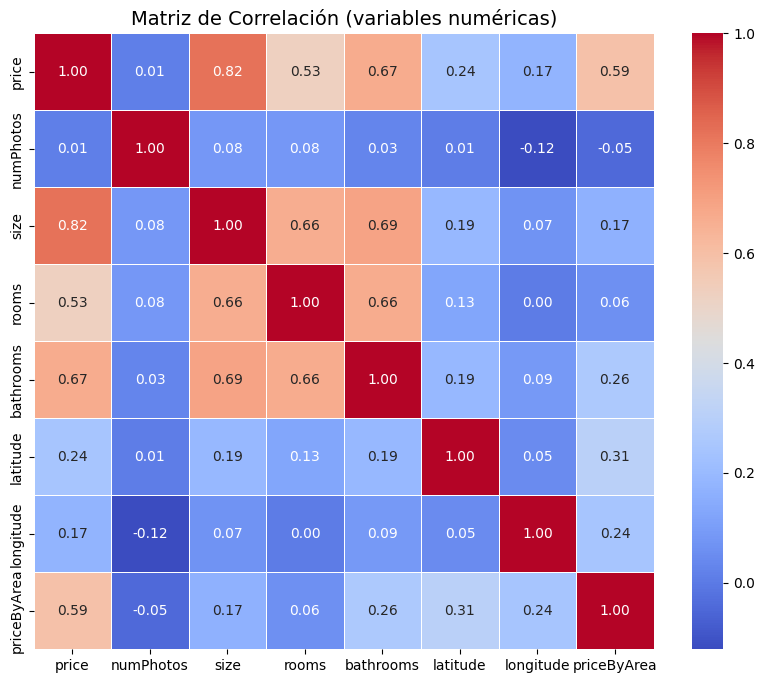

Correlación de cada variable con 'price':

price          1.000000
size           0.819999
bathrooms      0.666530
priceByArea    0.590509
rooms          0.526684
latitude       0.244338
longitude      0.172959
numPhotos      0.011260
Name: price, dtype: float64


In [62]:
# Matriz de correlación SOLO con las columnas numéricas
columnas_numericas = df3.select_dtypes(include=['float64', 'int64']).columns

# Crear matriz de correlación solo con las columnas numéricas
matriz_corr = df3[columnas_numericas].corr()

# Ordenar las columnas en función de su correlación con 'price'
matriz_corr_target = matriz_corr['price'].sort_values(ascending=False)

# Visualizar como un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación (variables numéricas)', fontsize=14)
plt.show()

# Mostrar correlación específica de las variables con el target 'price'
print("Correlación de cada variable con 'price':\n")
print(matriz_corr_target)


In [63]:
# Función para matriz de correlación
def cramer(x, y):
    """Calcula el coeficiente de Cramer para dos variables categóricas."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

def correlacion(dataframe, booleanas=None, categoricas=None, mostrar_valores=True):
    """
    Calcula y grafica la matriz de correlación de un DataFrame con opciones para incluir booleanos y categóricas.
    
    Parámetros:
    - dataframe: DataFrame con los datos.
    - booleanas: Si 'bool', convierte booleanos a dummies (0/1) para incluirlos en la correlación.
    - categoricas: Si 'Cramer', calcula la correlación entre variables categóricas usando Cramer’s V.
    - mostrar_valores: por defecto True, muestra los valores numéricos en el heatmap.
    
    Devuelve:
    - La matriz de correlación calculada.
    """
    
    df = dataframe.copy()
    
    # Convertir booleanos a numéricos si 'booleanas' es 'bool'
    if booleanas == 'bool':
        bool_cols = df.select_dtypes(include=['bool']).columns
        df[bool_cols] = df[bool_cols].astype(int)  # Convertir a 0/1
    
    # Seleccionar solo columnas numéricas
    columnas_numericas = df.select_dtypes(include=['float64', 'int64']).columns
    matriz_corr = df[columnas_numericas].corr()
    
    # Si se pide incluir categóricas con Cramer’s V
    if categoricas == 'Cramer':
        cat_cols = df.select_dtypes(include=['object', 'category']).columns
        if len(cat_cols) > 0:
            cramer_corr = pd.DataFrame(index=cat_cols, columns=cat_cols)
        
        for col1 in cat_cols:
            for col2 in cat_cols:
                if col1 == col2:
                    cramer_corr.loc[col1, col2] = 1  # Autocorrelación
                else:
                    cramer_corr.loc[col1, col2] = cramer(df[col1], df[col2])
        
        cramer_corr = cramer_corr.astype(float)
        matriz_corr = matriz_corr.combine_first(cramer_corr)  # Unir ambas matrices

    # Ordenar las columnas en función de su correlación con 'price'
    if 'price' in matriz_corr.columns:
        matriz_corr_target = matriz_corr['price'].sort_values(ascending=False)
        print("\nCorrelación de cada variable con 'price':\n")
        print(matriz_corr_target)
    
    # Graficar heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(matriz_corr, annot=mostrar_valores, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Matriz de Correlación', fontsize=14)
    plt.show()
    
    return matriz_corr



Correlación de cada variable con 'price':

price          1.000000
size           0.819999
bathrooms      0.666530
priceByArea    0.590509
rooms          0.526684
latitude       0.244338
longitude      0.172959
numPhotos      0.011260
Name: price, dtype: float64


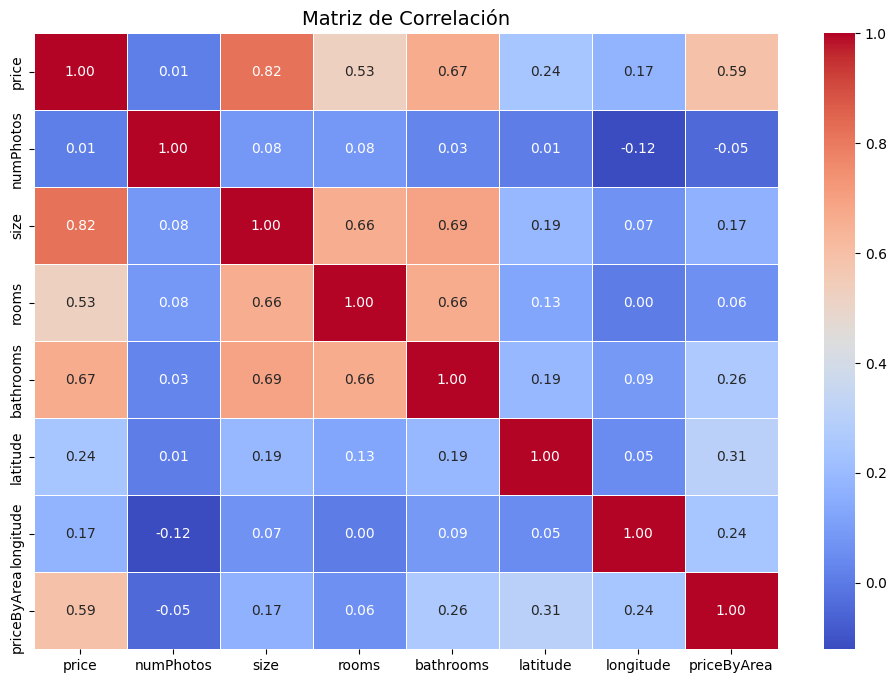

price  numPhotos      size     rooms  bathrooms  latitude  \
price        1.000000   0.011260  0.819999  0.526684   0.666530  0.244338   
numPhotos    0.011260   1.000000  0.081849  0.082265   0.030538  0.006107   
size         0.819999   0.081849  1.000000  0.662426   0.691208  0.192228   
rooms        0.526684   0.082265  0.662426  1.000000   0.664433  0.126278   
bathrooms    0.666530   0.030538  0.691208  0.664433   1.000000  0.192514   
latitude     0.244338   0.006107  0.192228  0.126278   0.192514  1.000000   
longitude    0.172959  -0.121009  0.068615  0.004877   0.087014  0.049093   
priceByArea  0.590509  -0.046092  0.167719  0.059791   0.262933  0.305116   

             longitude  priceByArea  
price         0.172959     0.590509  
numPhotos    -0.121009    -0.046092  
size          0.068615     0.167719  
rooms         0.004877     0.059791  
bathrooms     0.087014     0.262933  
latitude      0.049093     0.305116  
longitude     1.000000     0.242919  
priceByArea   0.242919     1.000000

In [64]:
correlacion (df3)

In [65]:
#Corrrelación limitada a price, priceByArea y size
# Seleccionar las columnas de interés
# cols = ['price', 'priceByArea', 'size']

# # Calcular la matriz de correlación
# corr_matrix = df3[cols].corr()

# # Visualizar la matriz de correlación con un heatmap
# plt.figure(figsize=(6, 4))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.title("Matriz de Correlación entre Price, PriceByArea y Size")
# plt.show()


Si bien fruto de la anterior matriz de correlación, procedería eliminar size como la que menos información aporta y alta correlación con price, parece bastante trampa, pues es un dato que se obtiene teniendo el precio de partida. Como esto no sucederá en datos futuros ni en test, y no debe suceder en validation, voy a eliminarla en este momento

In [66]:
df3.drop('priceByArea', axis=1, inplace=True)

#### Conversiones numéricas básicas

In [67]:
df3_num = df3.copy()

##### Conversión numérica mediante mapeo de 'floor'


In [68]:
# Celda para encontrar detalle del significado de 'st' en 'floor' en la columna descripción
# Ajustar pandas para que no trunque el texto
pd.set_option('display.max_colwidth', None)

# Filtrar las filas donde 'floor' es igual a 'st'
df3[df3['floor'] == 'st'][['floor', 'description']]


floor  \
ID                
105501758    st   
107058286    st   
107058336    st   
107058302    st   
105718088    st   
105535991    st   
104520166    st   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         description  
ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [69]:
def convertir_floor_flotante(dataframe):
    """
    Convierte la columna 'floor' a valores numéricos según un mapeo predefinido.
    
    - Si el valor ya es numérico, se mantiene.
    - Si es un texto reconocido ('bj', 'ss', etc.), se mapea a un número.
    - Si es un número en texto ('3', '-1', etc.), se convierte a número.
    - Si es un valor desconocido o vacío, se asigna 0.

    :param dataframe: DataFrame con la columna 'floor'.
    :return: DataFrame con 'floor' en formato numérico.
    """
    # Diccionario de mapeo
    floor_mapping = {
        'entreplanta': 0.5, 'ent': 0.5, 'en': 0.5,
        'baja': 0, 'bajo': 0, 'bj': 0, 'street': 0, 'st': 0,
        'semisótano': -0.5, 'semisotano': -0.5, 'ss': -0.5,
        'sótano': -1, 'sotano': -1, 'sot': -1
    }

    def map_floor(value):
        # Si ya es numérico, se mantiene
        if isinstance(value, (int, float)):
            return value

        # Si el valor es NaN o None, asignar 0
        if pd.isna(value):
            return 0

        # Convertir a string y limpiar espacios
        value = str(value).strip().lower()

        # Si está en el diccionario, aplicar el mapeo
        if value in floor_mapping:
            return floor_mapping[value]

        # Intentar convertir números en string ('3', '-1', etc.)
        try:
            return int(value) if value.isdigit() or value.lstrip('-').isdigit() else float(value)
        except ValueError:
            return 0  # Valores desconocidos se asignan a 0

    # Aplicar la función y forzar a numérico
    dataframe['floor'] = dataframe['floor'].apply(map_floor)

    return dataframe


In [70]:
pd.set_option('display.max_colwidth', None)
df3_num = convertir_floor_flotante(df3_num)
df3_num.head(5)

price  terraza  numPhotos  floor propertyType   size  exterior  \
ID                                                                              
107526421  1095000.0    False         43    3.0         flat  146.0      True   
107246640  1195000.0    False         27    2.0         flat  134.0      True   
106773918   790000.0    False         33    3.0         flat  148.0      True   
102711209  2350000.0     True         44    5.0         flat  218.0      True   
106822977   235000.0    False         34    0.0       studio   38.0     False   

           rooms  bathrooms                      address  ...  \
ID                                                        ...   
107526421      3          2         calle de las Fuentes  ...   
107246640      3          3      calle del Divino Pastor  ...   
106773918      2          2  Barrio Lavapiés-Embajadores  ...   
102711209      4          4      Carrera de San Jerónimo  ...   
106822977      0          1          calle de San Andrés  ...   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [71]:
df3_num['floor'].unique()

array([ 3. ,  2. ,  5. ,  0. ,  4. ,  6. , 10. ,  1. ,  8. ,  0.5, 11. ,
        9. , -0.5, -1. ,  7. ])

##### Conversión numérica mediante mapeo de 'status'

In [72]:
df3_num['status'].unique()

<StringArray>
['good', 'renew', 'newdevelopment', 'Nueva']
Length: 4, dtype: string

In [73]:
def mapear_status(dataframe):
    """
    Convierte la columna 'status' a valores numéricos según un mapeo predefinido.
    
    - 'Nueva' y 'newdevelopment' → 2
    - 'good' → 1
    - 'renew' → 0
    - Cualquier otro valor (incluyendo NaN) → 0

    :param dataframe: DataFrame con la columna 'status'.
    :return: DataFrame con 'status' en formato numérico.
    """
    # Diccionario de mapeo
    status_mapping = {
        'nueva': 2, 'newdevelopment': 2,
        'good': 1,
        'renew': 0
    }

    def map_status(value):
        # Si ya es numérico, se mantiene
        if isinstance(value, (int, float)):
            return value

        # Si el valor es NaN o None, asignar 0
        if pd.isna(value):
            return 0

        # Convertir a string y limpiar espacios
        value = str(value).strip().lower()

        # Si está en el diccionario, aplicar el mapeo
        return status_mapping.get(value, 0)

    # Aplicar la función y forzar a numérico
    dataframe['status'] = dataframe['status'].apply(map_status)

    return dataframe


In [74]:
df3_num= mapear_status (df3_num)

In [75]:
df3_num['status'].unique()

array([1, 0, 2])

##### Conversión automática resto de columnas binarias y (algunas) categóricas 

In [76]:
df3_num['propertyType'].unique()

<StringArray>
['flat', 'studio', 'penthouse', 'duplex']
Length: 4, dtype: string

In [77]:
def convertir_a_numerico (dataframe):
    """
    Convierte los valores del DataFrame:
    - Convierte columnas booleanas a 0 y 1.
    - Renombra 'district' → 'distrito' y 'neighborhood' → 'barrio'.
    - Usa one-hot encoding para 'district' y 'neighborhood', si existen en el DataFrame.
    - Renombra 'propertyType' → 'tipo' y usa one-hot encoding para 'tipo'.

    :param dataframe: DataFrame de entrada.
    :return: DataFrame transformado.
    """
    df_numerico = dataframe.copy()

    # Convertir booleanos a 0 y 1
    bool_cols = ['terraza', 'exterior', 'hasVideo', 'hasLift', 'hasPlan', 'has3DTour', 'has360', 'topPlus']
    for col in bool_cols:
        if col in df_numerico.columns:
            df_numerico[col] = df_numerico[col].astype(int)
            
    # Renombrar columnas antes de cualquier otra transformación
    df_numerico = df_numerico.rename(columns={'district': 'distrito', 'neighborhood': 'barrio' , 'propertyType': 'tipo'})

    # Aplicar one-hot encoding a 'district' y 'neighborhood' si existen
    for col in ['districto', 'barrio']:
        if col in df_numerico.columns:
            dummies = pd.get_dummies(df_numerico[col], prefix=col, dtype=int)
            df_numerico = pd.concat([df_numerico.drop(columns=[col]), dummies], axis=1)

    # Aplicar one-hot encoding a 'tipo' para las categorías especificadas
    if 'tipo' in df_numerico.columns:
        tipos = ['flat', 'studio', 'penthouse', 'duplex']
        # Verificar que las categorías estén en la columna 'tipo'
        for tipo in tipos:
            if tipo in df_numerico['tipo'].values:
                # Crear columnas one-hot para cada tipo
                df_numerico[f'tipo_{tipo}'] = (df_numerico['tipo'] == tipo).astype(int)
        # Borrar la columna original 'tipo' después del one-hot encoding
        # df_numerico = df_numerico.drop(columns=['tipo']) #no la borro, para el estudio de outliers. La borraré después
        
    return df_numerico


In [78]:
# Aplicar la conversión
df3_num = convertir_a_numerico(df3_num)
df3_num.head(1)

price  terraza  numPhotos  floor  tipo   size  exterior  rooms  \
ID                                                                              
107526421  1095000.0        0         43    3.0  flat  146.0         1      3   

           bathrooms               address  ...  barrio_Chueca-Justicia  \
ID                                          ...                           
107526421          2  calle de las Fuentes  ...                       0   

           barrio_Huertas-Cortes barrio_Lavapiés-Embajadores  \
ID                                                             
107526421                      0                           0   

           barrio_Malasaña-Universidad  barrio_Palacio  barrio_Sol  tipo_flat  \
ID                                                                              
107526421                            0               0           1          1   

           tipo_studio  tipo_penthouse  tipo_duplex  
ID                                                   
107526421            0               0            0  

[1 rows x 32 columns]

In [79]:
numericas (df3_num)

count           mean         median  \
columna                                                            
price                         1747  920737.967945  750000.000000   
terraza                       1747       0.103606       0.000000   
numPhotos                     1747      24.698912      23.000000   
floor                         1747       2.346308       2.000000   
size                          1747     114.033772     101.000000   
exterior                      1747       0.753291       1.000000   
rooms                         1747       2.358901       2.000000   
bathrooms                     1747       1.926159       2.000000   
latitude                      1747      40.417894      40.417730   
longitude                     1747      -3.703290      -3.702997   
hasVideo                      1747       0.333143       0.000000   
status                        1747       0.898111       1.000000   
hasLift                       1747       0.700057       1.000000   
hasPlan                       1747       0.512307       1.000000   
has3DTour                     1747       0.080710       0.000000   
has360                        1747       0.116772       0.000000   
topPlus                       1747       0.024041       0.000000   
barrio_Chueca-Justicia        1747       0.155123       0.000000   
barrio_Huertas-Cortes         1747       0.124785       0.000000   
barrio_Lavapiés-Embajadores   1747       0.184888       0.000000   
barrio_Malasaña-Universidad   1747       0.237550       0.000000   
barrio_Palacio                1747       0.144820       0.000000   
barrio_Sol                    1747       0.152833       0.000000   
tipo_flat                     1747       0.850029       1.000000   
tipo_studio                   1747       0.040641       0.000000   
tipo_penthouse                1747       0.067544       0.000000   
tipo_duplex                   1747       0.041786       0.000000   

                                     mode            std           min  \
columna                                                                  
price                        1.079000e+06  801363.295011  79900.000000   
terraza                      0.000000e+00       0.304836      0.000000   
numPhotos                    1.500000e+01      15.012779      0.000000   
floor                        1.000000e+00       1.791219     -1.000000   
size                         1.120000e+02      76.019828     11.000000   
exterior                     1.000000e+00       0.431219      0.000000   
rooms                        2.000000e+00       1.413397      0.000000   
bathrooms                    1.000000e+00       1.109543      0.000000   
latitude                     4.041190e+01       0.006299     40.404105   
longitude                   -3.694260e+00       0.005117     -3.718611   
hasVideo                     0.000000e+00       0.471472      0.000000   
status                       1.000000e+00       0.364413      0.000000   
hasLift                      1.000000e+00       0.458364      0.000000   
hasPlan                      1.000000e+00       0.499992      0.000000   
has3DTour                    0.000000e+00       0.272467      0.000000   
has360                       0.000000e+00       0.321240      0.000000   
topPlus                      0.000000e+00       0.153221      0.000000   
barrio_Chueca-Justicia       0.000000e+00       0.362126      0.000000   
barrio_Huertas-Cortes        0.000000e+00       0.330570      0.000000   
barrio_Lavapiés-Embajadores  0.000000e+00       0.388318      0.000000   
barrio_Malasaña-Universidad  0.000000e+00       0.425704      0.000000   
barrio_Palacio               0.000000e+00       0.352020      0.000000   
barrio_Sol                   0.000000e+00       0.359930      0.000000   
tipo_flat                    1.000000e+00       0.357146      0.000000   
tipo_studio                  0.000000e+00       0.197514      0.000000   
tipo_penthouse               0.000000e+00       0.251034  

In [80]:
crear_tabla_resumen (df3_num)

Tipo de dato           Categoría  Cardinalidad  \
Columna                                                                         
price                               float64   Numérica Continua           505   
terraza                               int64   Numérica Discreta             2   
numPhotos                             int64   Numérica Discreta            81   
floor                               float64   Numérica Continua            15   
tipo                         string[python]  Categórica Nominal             4   
size                                float64   Numérica Continua           261   
exterior                              int64   Numérica Discreta             2   
rooms                                 int64   Numérica Discreta            12   
bathrooms                             int64   Numérica Discreta            10   
address                              object  Categórica Nominal           524   
latitude                            float64   Numérica Continua          1698   
longitude                           float64   Numérica Continua          1700   
description                          object  Categórica Nominal          1698   
hasVideo                              int64   Numérica Discreta             2   
status                                int64   Numérica Discreta             3   
hasLift                               int64   Numérica Discreta             2   
hasPlan                               int64   Numérica Discreta             2   
has3DTour                             int64   Numérica Discreta             2   
has360                                int64   Numérica Discreta             2   
topPlus                               int64   Numérica Discreta             2   
suggestedTexts_subtitle              object  Categórica Nominal             6   
suggestedTexts_title                 object  Categórica Nominal           612   
barrio_Chueca-Justicia                int64   Numérica Discreta             2   
barrio_Huertas-Cortes                 int64   Numérica Discreta             2   
barrio_Lavapiés-Embajadores           int64   Numérica Discreta             2   
barrio_Malasaña-Universidad           int64   Numérica Discreta             2   
barrio_Palacio                        int64   Numérica Discreta             2   
barrio_Sol                            int64   Numérica Discreta             2   
tipo_flat                             int64   Numérica Discreta             2   
tipo_studio                           int64   Numérica Discreta             2   
tipo_penthouse                        int64   Numérica Discreta             2   
tipo_duplex                           int64   Numérica Discreta             2   

                             % Cardinalidad  Valores faltantes  \
Columna                                                          
price                             28.906697                  0   
terraza                            0.114482                  0   
numPhotos                          4.636520                  0   
floor                              0.858615                  0   
tipo                               0.228964                  0   
size                              14.939897                  0   
exterior                           0.114482                  0   
rooms                              0.686892                  0   
bathrooms                          0.572410                  0   
address                           29.994276                  0   
latitude                          97.195192                  0   
longitude                         97.309674                  0   
description                       97.195192                  0   
hasVideo                           0.114482                  0   
status                             0.171723                  0   
hasLift                            0.114482                  0   
hasPlan                            0.114482                  0   
has3DTour             

In [81]:
# Con los datos, función para convertir en csv y guardarlo.
today =  date.today ()
file_path = f'../data/processed/ide_viv_numerico0_{today}.csv' 

def df_to_csv(df):
    if os.path.exists(file_path):
        print(f"⚠️ El archivo '{file_path}' ya existe. No se sobrescribirá.")
    else:
        df.to_csv(file_path)   #lo guarda en un csv con indice en propertyCode
        print(f"✅ Archivo guardado correctamente como '{file_path}'.")

In [82]:
#Guarda los datos pre separación Train-test en un csv con nombre establecido.
df_to_csv(df3_num)

⚠️ El archivo '../data/processed/ide_viv_numerico0_2025-03-20.csv' ya existe. No se sobrescribirá.



Correlación de cada variable con 'price':

price                          1.000000
size                           0.819999
bathrooms                      0.666530
rooms                          0.526684
exterior                       0.355099
hasLift                        0.311627
barrio_Chueca-Justicia         0.269748
latitude                       0.244338
longitude                      0.172959
floor                          0.157962
barrio_Huertas-Cortes          0.125876
terraza                        0.110304
topPlus                        0.080559
tipo_penthouse                 0.075023
status                         0.069495
barrio_Sol                     0.044563
hasPlan                        0.041717
tipo_flat                      0.033658
has3DTour                      0.018159
tipo_duplex                    0.014851
numPhotos                      0.011260
barrio_Palacio                -0.037520
has360                        -0.048864
barrio_Malasaña-Universidad   -0.060

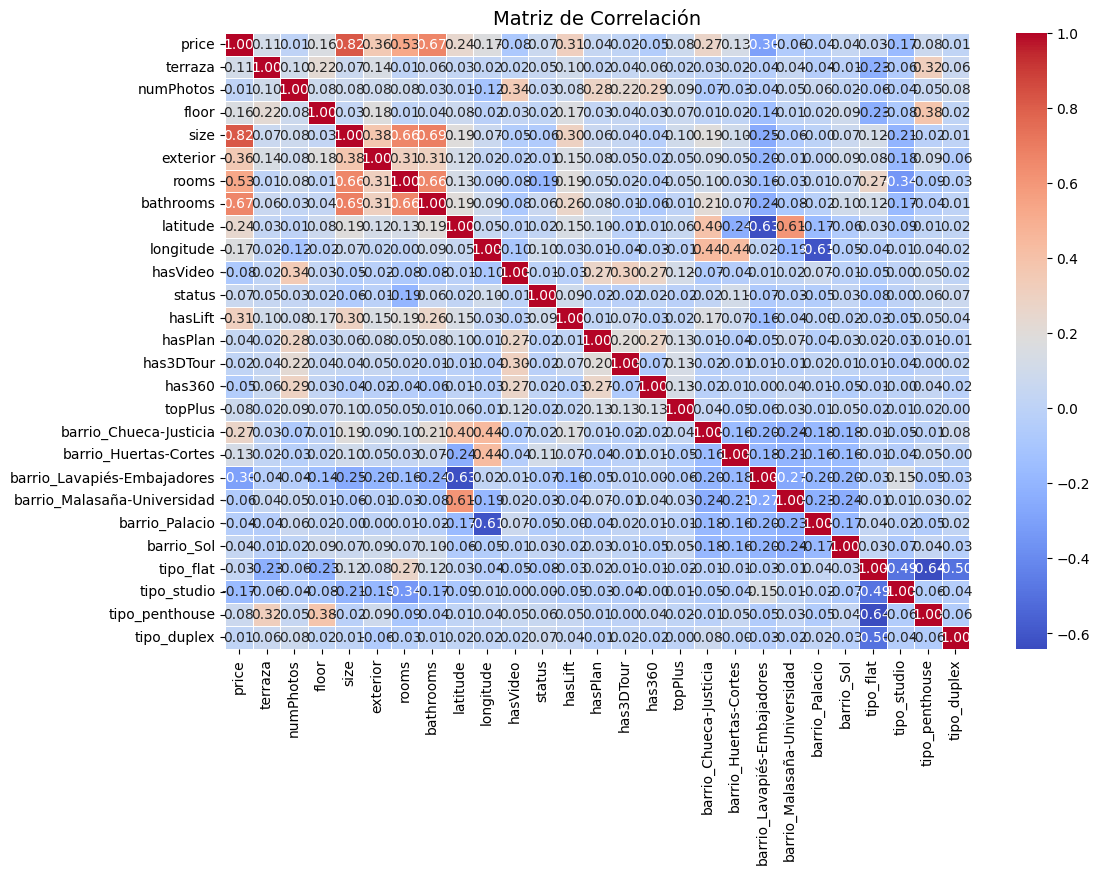

price   terraza  numPhotos     floor  \
price                        1.000000  0.110304   0.011260  0.157962   
terraza                      0.110304  1.000000   0.099055  0.220606   
numPhotos                    0.011260  0.099055   1.000000  0.082630   
floor                        0.157962  0.220606   0.082630  1.000000   
size                         0.819999  0.069002   0.081849  0.028631   
exterior                     0.355099  0.142276   0.081236  0.182971   
rooms                        0.526684  0.008028   0.082265  0.009018   
bathrooms                    0.666530  0.061579   0.030538  0.038234   
latitude                     0.244338  0.026384   0.006107  0.076309   
longitude                    0.172959  0.019441  -0.121009 -0.015246   
hasVideo                    -0.079421  0.018735   0.340760  0.028110   
status                       0.069495  0.048680   0.033648  0.017235   
hasLift                      0.311627  0.099563   0.077674  0.165652   
hasPlan                      0.041717  0.023570   0.282885  0.029452   
has3DTour                    0.018159  0.044074   0.223671  0.043621   
has360                      -0.048864  0.057694   0.291721  0.028221   
topPlus                      0.080559  0.020215   0.093033  0.067728   
barrio_Chueca-Justicia       0.269748  0.025541  -0.066413  0.008080   
barrio_Huertas-Cortes        0.125876  0.019403  -0.031317  0.017899   
barrio_Lavapiés-Embajadores -0.299183 -0.036118  -0.038978 -0.141510   
barrio_Malasaña-Universidad -0.060951  0.039737   0.050270  0.014483   
barrio_Palacio              -0.037520 -0.038495   0.062009  0.023965   
barrio_Sol                   0.044563 -0.013900   0.017530  0.087535   
tipo_flat                    0.033658 -0.225448  -0.057884 -0.234804   
tipo_studio                 -0.171262 -0.060461  -0.038557 -0.077038   
tipo_penthouse               0.075023  0.320141   0.050383  0.379741   
tipo_duplex                  0.014851  0.060421   0.078142  0.018722   

                                 size  exterior     rooms  bathrooms  \
price                        0.819999  0.355099  0.526684   0.666530   
terraza                      0.069002  0.142276  0.008028   0.061579   
numPhotos                    0.081849  0.081236  0.082265   0.030538   
floor                        0.028631  0.182971  0.009018   0.038234   
size                         1.000000  0.378251  0.662426   0.691208   
exterior                     0.378251  1.000000  0.310749   0.306655   
rooms                        0.662426  0.310749  1.000000   0.664433   
bathrooms                    0.691208  0.306655  0.664433   1.000000   
latitude                     0.192228  0.115642  0.126278   0.192514   
longitude                    0.068615  0.022790  0.004877   0.087014   
hasVideo                    -0.049548 -0.023707 -0.078969  -0.082141   
status                      -0.062023 -0.006976 -0.192501   0.063539   
hasLift                      0.295546  0.149881  0.190129   0.263868   
hasPlan                      0.062606  0.081829  0.051694   0.079585   
has3DTour                    0.039078  0.047703  0.019921  -0.008693   
has360                      -0.037358 -0.015180 -0.041899  -0.064173   
topPlus                      0.100190  0.046478  0.047409   0.007079   
barrio_Chueca-Justicia       0.190426  0.091173  0.100417   0.212408   
barrio_Huertas-Cortes        0.100478  0.051358  0.032803   0.068859   
barrio_Lavapiés-Embajadores -0.253366 -0.199451 -0.156451  -0.242132   
barrio_Malasaña-Universidad -0.062315 -0.014402 -0.032311  -0.079248   
barrio_Palacio              -0.002880  0.001574  0.007135  -0.019530   
barrio_Sol                   0.065998  0.091778  0.068871   0.097114   
tipo_flat                    0.119480  0.075725  0.270073   0.115126   
tipo_studio                 -0.207941 -0.184814 -0.343607  -0.169240   
tipo_penthouse              -0.015246  0.085244 -0.090961  -0.039659   
tipo_duplex                  0.011124 -0.059657 -0.028748   0.011323   

In [83]:
correlacion (df3_num)

###
[Ir al principio de la sección 5](#reduccion-variables)


<a id="analisis-univariante"></a>
## 6. Análisis univariante

In [84]:
crear_tabla_resumen (df3)

Tipo de dato           Categoría  Cardinalidad  \
Columna                                                                     
price                           float64   Numérica Continua           505   
terraza                            bool         Desconocida             2   
numPhotos                         int64   Numérica Discreta            81   
floor                    string[python]  Categórica Nominal            17   
propertyType             string[python]  Categórica Nominal             4   
size                            float64   Numérica Continua           261   
exterior                           bool         Desconocida             2   
rooms                             int64   Numérica Discreta            12   
bathrooms                         int64   Numérica Discreta            10   
address                          object  Categórica Nominal           524   
neighborhood             string[python]  Categórica Nominal             6   
latitude                        float64   Numérica Continua          1698   
longitude                       float64   Numérica Continua          1700   
description                      object  Categórica Nominal          1698   
hasVideo                           bool         Desconocida             2   
status                   string[python]  Categórica Nominal             4   
hasLift                            bool         Desconocida             2   
hasPlan                            bool         Desconocida             2   
has3DTour                          bool         Desconocida             2   
has360                             bool         Desconocida             2   
topPlus                            bool         Desconocida             2   
suggestedTexts_subtitle          object  Categórica Nominal             6   
suggestedTexts_title             object  Categórica Nominal           612   

                         % Cardinalidad  Valores faltantes  \
Columna                                                      
price                         28.906697                  0   
terraza                        0.114482                  0   
numPhotos                      4.636520                  0   
floor                          0.973097                  0   
propertyType                   0.228964                  0   
size                          14.939897                  0   
exterior                       0.114482                  0   
rooms                          0.686892                  0   
bathrooms                      0.572410                  0   
address                       29.994276                  0   
neighborhood                   0.343446                  0   
latitude                      97.195192                  0   
longitude                     97.309674                  0   
description                   97.195192                  0   
hasVideo                       0.114482                  0   
status                         0.228964                  0   
hasLift                        0.114482                  0   
hasPlan                        0.114482                  0   
has3DTour                      0.114482                  0   
has360                         0.114482                  0   
topPlus                        0.114482                  0   
suggestedTexts_subtitle        0.343446                  0   
suggestedTexts_title          35.031483                  0   

                         % Valores faltantes  
Columna                                       
price                                    0.0  
terraza                                  0.0  
numPhotos                                0.0  
floor                                    0.0  
propertyType                             0.0  
size                                     0.0  
exterior                                 0.0  
rooms                                    0.0  
bathrooms                                0.0  
address                          

In [85]:
# Función para gráficos univariante 

def graficos_uni(dataframe):
    """
    Genera gráficos de distribución:
    - Barras para variables categóricas, discretas y booleanas.
    - Histogramas para variables continuas.

    Parámetro:
    - dataframe: DataFrame con los datos.
    """
    df = dataframe.copy()

    # Excluir columnas no deseadas
    excluidas = {'address', 'description', 'suggestedTexts_title'}
    df = df.drop(columns=[col for col in excluidas if col in df.columns])

    # Clasificar variables
    categ_discretas = df.select_dtypes(include=['object', 'category']).columns.tolist()
    categ_discretas += [col for col in df.select_dtypes(include=['int64']).columns if df[col].nunique() <= 15]
    bool_vars = df.select_dtypes(include=['bool']).columns.tolist()
    continuas = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col not in categ_discretas]

    num_vars = len(categ_discretas) + len(bool_vars) + len(continuas)
    filas = -(-num_vars // 2)  # Redondeo hacia arriba

    fig, axes = plt.subplots(filas, 2, figsize=(15, filas * 4))
    axes = axes.flatten()

    i = 0
    for col in categ_discretas:
        sns.countplot(data=df, x=col, hue=col, ax=axes[i], legend=False,palette= 'light:gray')
        axes[i].set_title(f"Distribución de {col}")
        axes[i].tick_params(axis='x', rotation=45)
        i += 1

    for col in bool_vars:
        sns.countplot(data=df, x=col, hue=col, ax=axes[i], palette={False: 'lightcoral', True: 'lightgreen'}, legend=False)
        axes[i].set_title(f"Distribución de {col}")
        i += 1

    for col in continuas:
        sns.histplot(df[col], kde=True, ax=axes[i], bins=30, color="gray", edgecolor="black")
        sns.kdeplot(df[col], ax=axes[i], color="red", linewidth=2)
        axes[i].set_title(f"Distribución de {col}")
        i += 1

    for j in range(i, len(axes)):  # Ocultar ejes vacíos
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


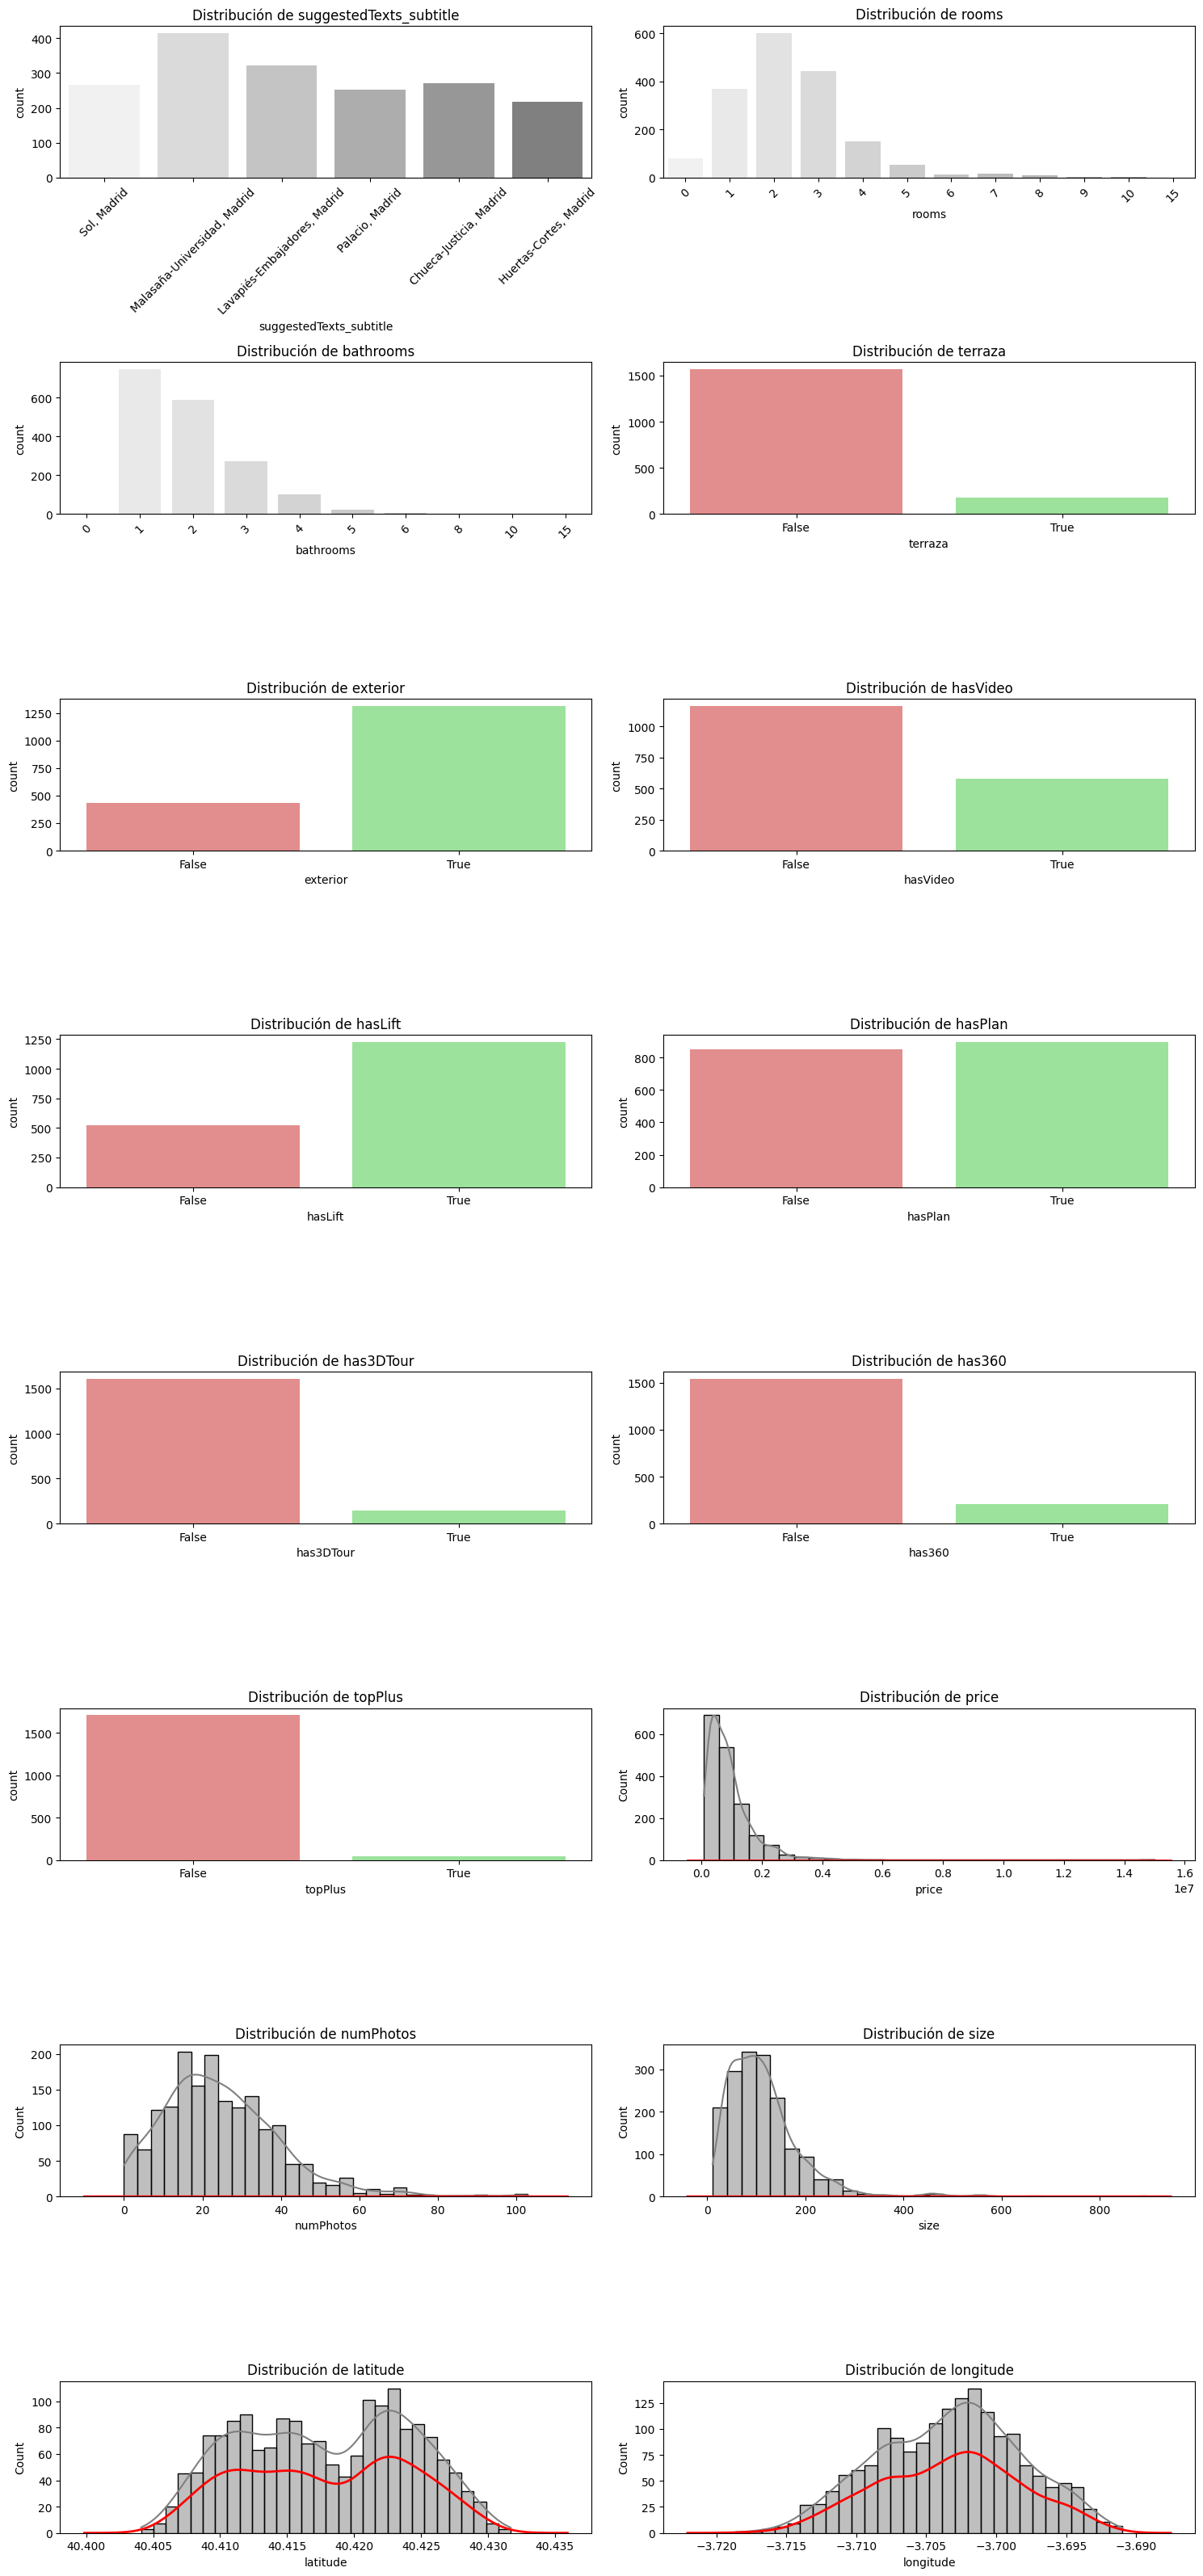

In [86]:
graficos_uni (df3)

[ir al inicio de la sección 6](#analisis-univariante)

<a id="analisis-bivariante"></a>
## 7. Análisis bivariante

In [87]:
df3_num.shape

(1747, 32)

<Figure size 1200x800 with 0 Axes>

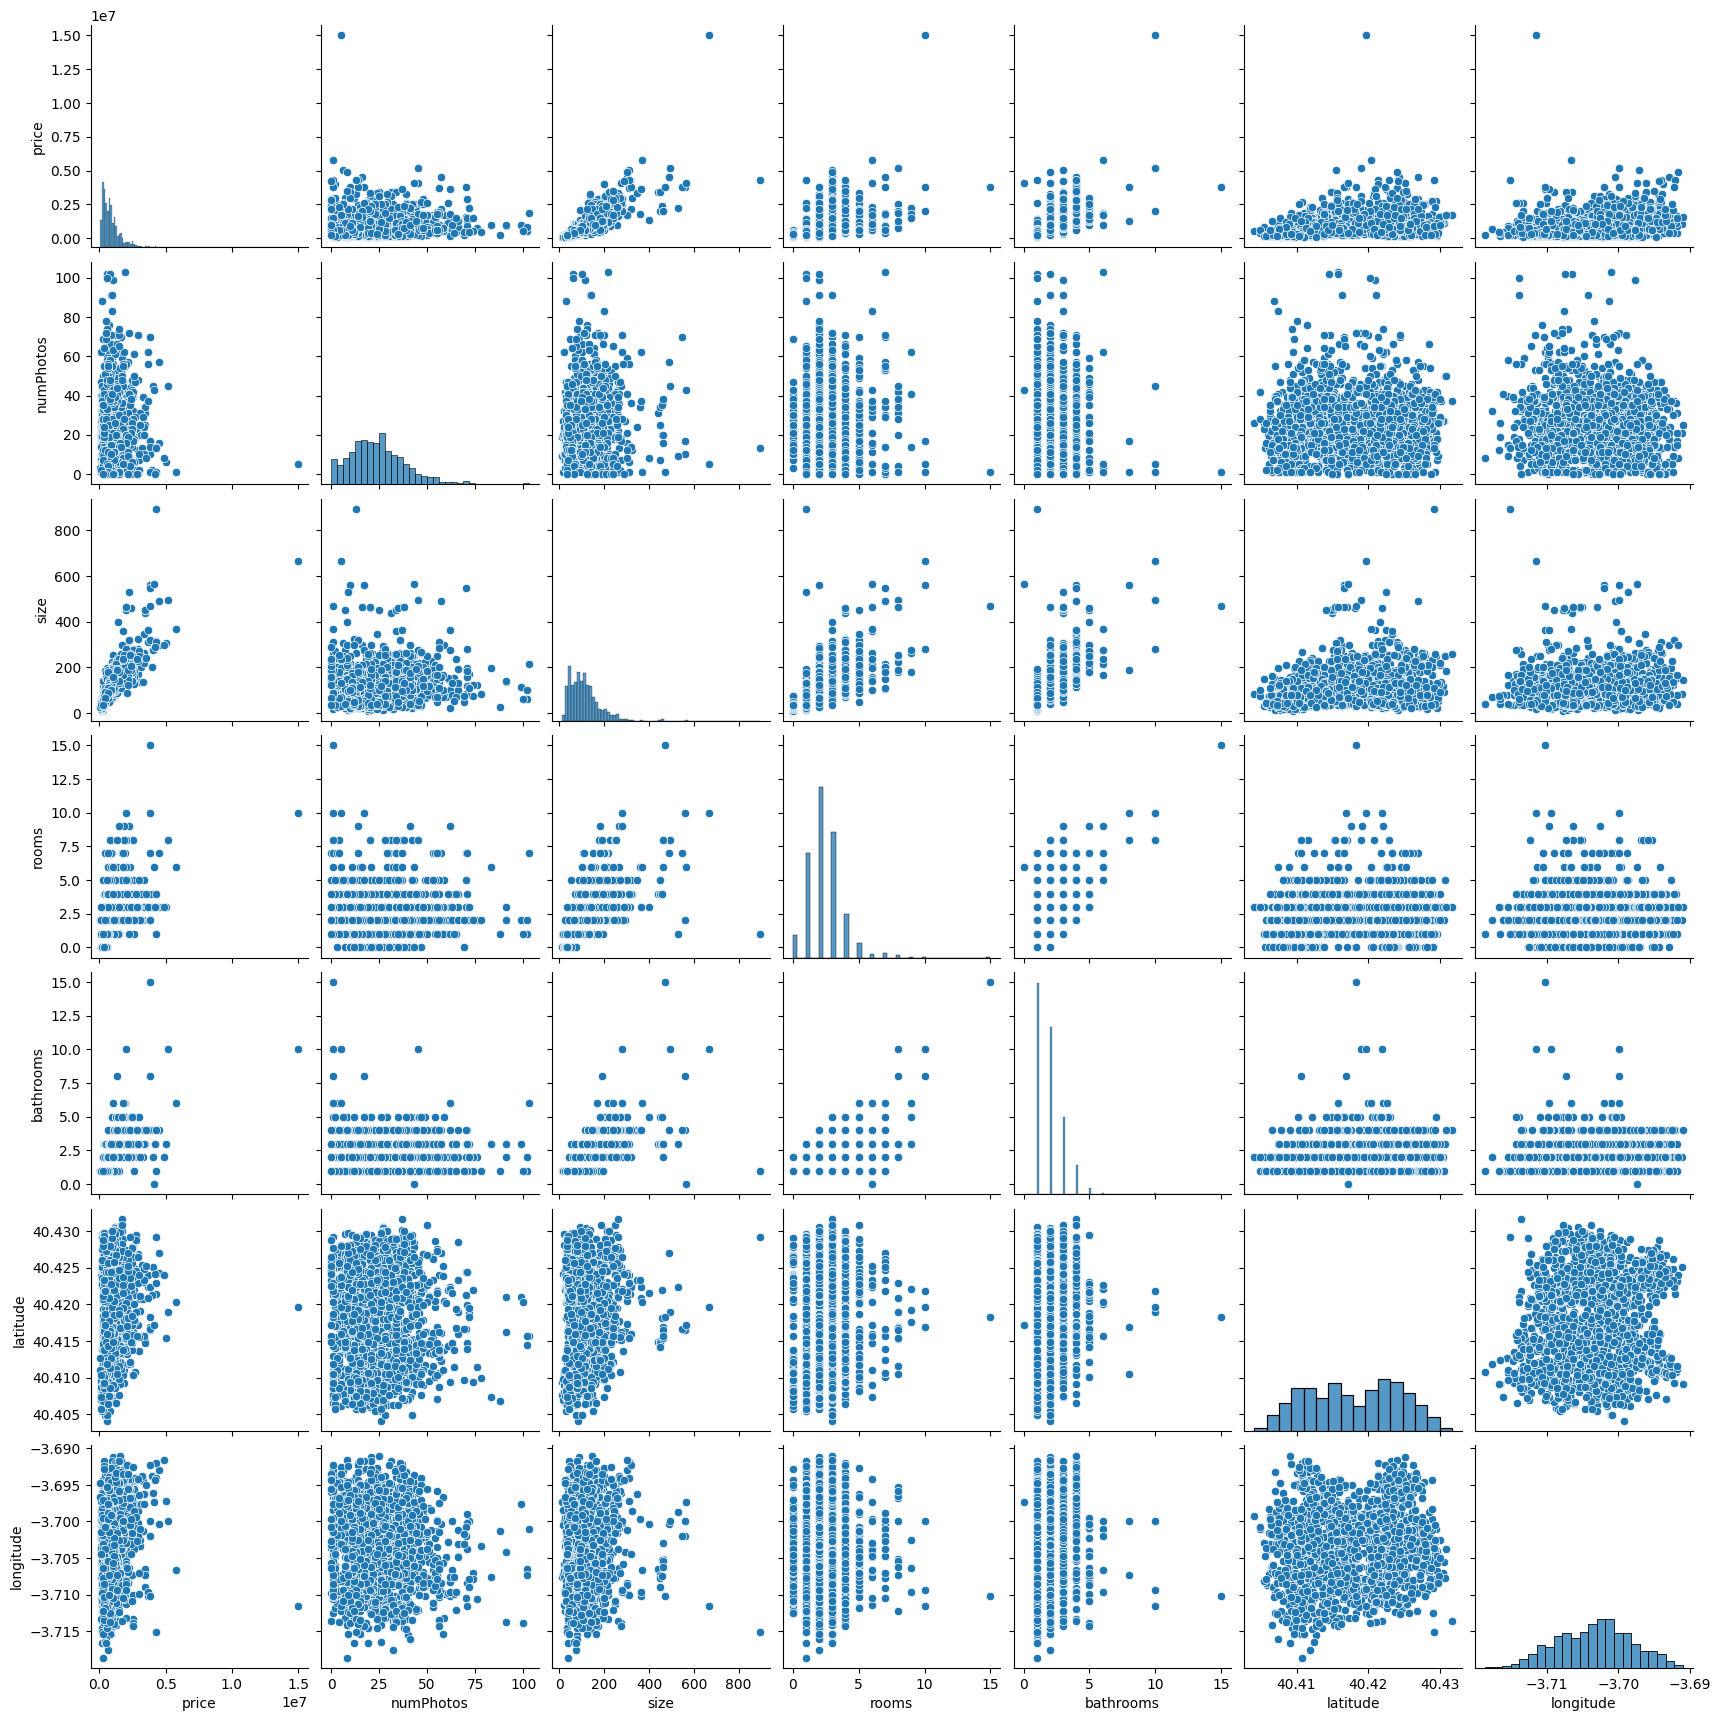

In [88]:
# Asegúrate de tener solo las variables numéricas, excluidas categóricas
df3_pair = df3.select_dtypes(include=['float64', 'int64'])

# Usamos pairplot con el target 'price' para diferenciar por colores
plt.figure(figsize=(12,8))
sns.pairplot(df3_pair, diag_kind='hist')
#sns.pairplot(df3_pair, kind='scatter')
plt.show()

In [89]:
df3_pair.shape

(1747, 7)

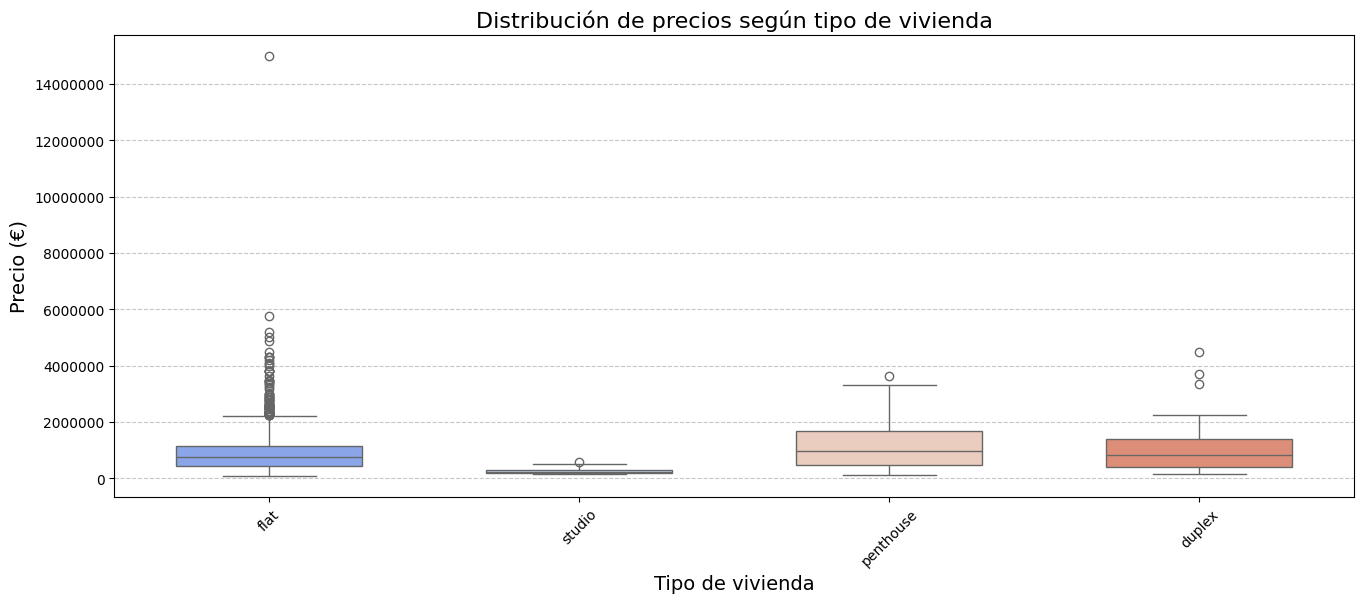

In [90]:
plt.figure(figsize=(16, 6))  # Gráfico más grande para evitar achatamiento

# Boxplot con mejor ajuste de tamaño
sns.boxplot(data=df3, x='propertyType', y='price', hue='propertyType', palette='coolwarm', width=0.6)

# Ajustes estéticos
plt.title('Distribución de precios según tipo de vivienda', fontsize=16)
plt.xlabel('Tipo de vivienda', fontsize=14)
plt.ylabel('Precio (€)', fontsize=14)
plt.xticks(rotation=45)  # Rotar etiquetas si es necesario

# Evitar notación científica en el eje Y
plt.ticklabel_format(style='plain', axis='y')

# Agregar una cuadrícula horizontal para mejor referencia
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Guardar imagen
plt.savefig('graf/boxplot_vivienda_precio.png', dpi=150, bbox_inches='tight')

# Mostrar gráfico
plt.show()


In [91]:
df3[df3['price'] > 6_000_000]



price  terraza  numPhotos floor propertyType   size  exterior  \
ID                                                                              
106035767  15000000.0    False          5     2         flat  666.0      True   

           rooms  bathrooms           address  ...  \
ID                                             ...   
106035767     10         10  calle de Arrieta  ...   

                                                                                                                                                                  description  \
ID                                                                                                                                                                              
106035767  Servicheck, le ofrece la oportunidad de comprar una vivienda unica en madrid piso en edificio exclisivo exterior con espectaculares vistas, unico en planta 666m2.   

           hasVideo  status hasLift  hasPlan has3DTour  has360  topPlus  \
ID                                                                        
106035767     False    good    True    False     False   False    False   

           suggestedTexts_subtitle      suggestedTexts_title  
ID                                                            
106035767          Palacio, Madrid  Piso en calle de Arrieta  

[1 rows x 23 columns]

In [92]:
df3 = df3[df3.index != 106035767]
df3_num = df3_num[df3_num.index != 106035767]



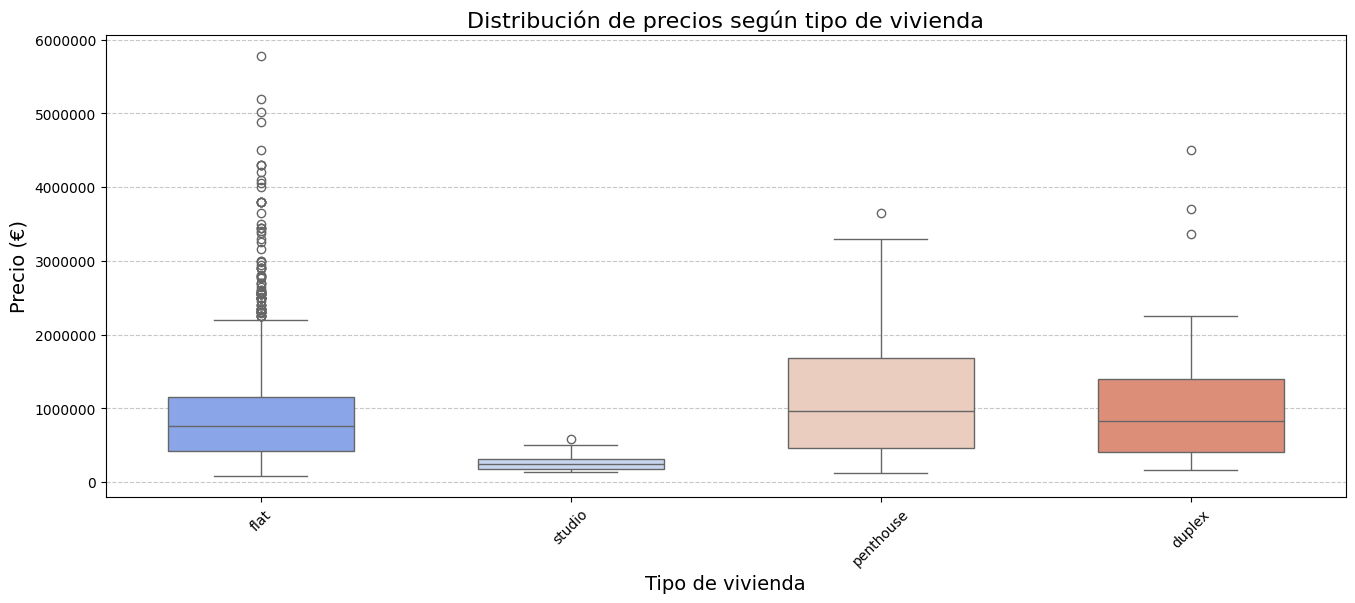

In [93]:
plt.figure(figsize=(16, 6))  # Gráfico más grande para evitar achatamiento

# Boxplot con mejor ajuste de tamaño
sns.boxplot(data=df3, x='propertyType', y='price', hue='propertyType', palette='coolwarm', width=0.6)

# Ajustes estéticos
plt.title('Distribución de precios según tipo de vivienda', fontsize=16)
plt.xlabel('Tipo de vivienda', fontsize=14)
plt.ylabel('Precio (€)', fontsize=14)
plt.xticks(rotation=45)  # Rotar etiquetas si es necesario

# Evitar notación científica en el eje Y
plt.ticklabel_format(style='plain', axis='y')

# Agregar una cuadrícula horizontal para mejor referencia
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Guardar imagen
plt.savefig('graf/boxplot_vivienda_precio.png', dpi=150, bbox_inches='tight')

# Mostrar gráfico
plt.show()


[ir al inicio de la sección 7](#analisis-bivariante)

<a id="eliminacion-variables"></a>  
## 8. Eliminación de variables

In [94]:
crear_tabla_resumen(df3_num)

Tipo de dato           Categoría  Cardinalidad  \
Columna                                                                         
price                               float64   Numérica Continua           504   
terraza                               int64   Numérica Discreta             2   
numPhotos                             int64   Numérica Discreta            81   
floor                               float64   Numérica Continua            15   
tipo                         string[python]  Categórica Nominal             4   
size                                float64   Numérica Continua           260   
exterior                              int64   Numérica Discreta             2   
rooms                                 int64   Numérica Discreta            12   
bathrooms                             int64   Numérica Discreta            10   
address                              object  Categórica Nominal           524   
latitude                            float64   Numérica Continua          1697   
longitude                           float64   Numérica Continua          1699   
description                          object  Categórica Nominal          1697   
hasVideo                              int64   Numérica Discreta             2   
status                                int64   Numérica Discreta             3   
hasLift                               int64   Numérica Discreta             2   
hasPlan                               int64   Numérica Discreta             2   
has3DTour                             int64   Numérica Discreta             2   
has360                                int64   Numérica Discreta             2   
topPlus                               int64   Numérica Discreta             2   
suggestedTexts_subtitle              object  Categórica Nominal             6   
suggestedTexts_title                 object  Categórica Nominal           612   
barrio_Chueca-Justicia                int64   Numérica Discreta             2   
barrio_Huertas-Cortes                 int64   Numérica Discreta             2   
barrio_Lavapiés-Embajadores           int64   Numérica Discreta             2   
barrio_Malasaña-Universidad           int64   Numérica Discreta             2   
barrio_Palacio                        int64   Numérica Discreta             2   
barrio_Sol                            int64   Numérica Discreta             2   
tipo_flat                             int64   Numérica Discreta             2   
tipo_studio                           int64   Numérica Discreta             2   
tipo_penthouse                        int64   Numérica Discreta             2   
tipo_duplex                           int64   Numérica Discreta             2   

                             % Cardinalidad  Valores faltantes  \
Columna                                                          
price                             28.865979                  0   
terraza                            0.114548                  0   
numPhotos                          4.639175                  0   
floor                              0.859107                  0   
tipo                               0.229095                  0   
size                              14.891180                  0   
exterior                           0.114548                  0   
rooms                              0.687285                  0   
bathrooms                          0.572738                  0   
address                           30.011455                  0   
latitude                          97.193585                  0   
longitude                         97.308133                  0   
description                       97.193585                  0   
hasVideo                           0.114548                  0   
status                             0.171821                  0   
hasLift                            0.114548                  0   
hasPlan                            0.114548                  0   
has3DTour             

Vamos a limpiar nuestros datos, después de analizados. Eliminaremos aquellas columnas de texto largo, descripción, dirección y título. También aquellas con alta cardinalidad, latitud y longitud. 

In [95]:
df3[['suggestedTexts_subtitle', 'neighborhood']]


suggestedTexts_subtitle          neighborhood
ID                                                           
107526421                   Sol, Madrid                   Sol
107246640  Malasaña-Universidad, Madrid  Malasaña-Universidad
106773918  Lavapiés-Embajadores, Madrid  Lavapiés-Embajadores
102711209                   Sol, Madrid                   Sol
106822977  Malasaña-Universidad, Madrid  Malasaña-Universidad
...                                 ...                   ...
107419060       Chueca-Justicia, Madrid       Chueca-Justicia
106976644                   Sol, Madrid                   Sol
107230033       Chueca-Justicia, Madrid       Chueca-Justicia
106530192  Lavapiés-Embajadores, Madrid  Lavapiés-Embajadores
107518858  Malasaña-Universidad, Madrid  Malasaña-Universidad

[1746 rows x 2 columns]

Comprobado que ambas columnas contienen los mismos datos, para mis efectos, eliminaré también la columna suggestedTexts_subtitle

In [96]:
def eliminar_variables(dataframe):
    """
    Elimina las columnas de texto largo (descripción, dirección, etc.) y columnas con alta cardinalidad 
    como latitud y longitud.
    
    :param dataframe: DataFrame de entrada.
    :return: DataFrame sin las columnas no deseadas.
    """
    df_limpio = dataframe.copy()
    
    # Eliminar columnas de texto largo
    columnas_texto_largo = ['description', 'address', 'suggestedTexts_title' ,'suggestedTexts_subtitle']
    df_limpio = df_limpio.drop(columns=[col for col in columnas_texto_largo if col in df_limpio.columns])
    
    # Eliminar columnas con alta cardinalidad (latitud y longitud, o más de 100 valores únicos)
    columnas_alta_cardinalidad = ['latitude', 'longitude']
    
    # También podemos eliminar aquellas columnas con más de 100 valores únicos (como un criterio genérico de alta cardinalidad)
    for col in df_limpio.select_dtypes(include=['object']).columns:
        if df_limpio[col].nunique() > 100:  # Umbral de cardinalidad alta
            columnas_alta_cardinalidad.append(col)

    # Eliminar las columnas con alta cardinalidad
    df_limpio = df_limpio.drop(columns=[col for col in columnas_alta_cardinalidad if col in df_limpio.columns])

    return df_limpio


In [97]:
df3_num

price  terraza  numPhotos  floor       tipo   size  exterior  \
ID                                                                            
107526421  1095000.0        0         43    3.0       flat  146.0         1   
107246640  1195000.0        0         27    2.0       flat  134.0         1   
106773918   790000.0        0         33    3.0       flat  148.0         1   
102711209  2350000.0        1         44    5.0       flat  218.0         1   
106822977   235000.0        0         34    0.0     studio   38.0         0   
...              ...      ...        ...    ...        ...    ...       ...   
107419060  4200000.0        0          0    3.0       flat  288.0         1   
106976644  2810000.0        0          0    1.0       flat  238.0         1   
107230033  2170000.0        1          0    4.0  penthouse  125.0         1   
106530192   999000.0        0          0    3.0       flat  160.0         0   
107518858   259000.0        0          0    2.0       flat   34.0         0   

           rooms  bathrooms                      address  ...  \
ID                                                        ...   
107526421      3          2         calle de las Fuentes  ...   
107246640      3          3      calle del Divino Pastor  ...   
106773918      2          2  Barrio Lavapiés-Embajadores  ...   
102711209      4          4      Carrera de San Jerónimo  ...   
106822977      0          1          calle de San Andrés  ...   
...          ...        ...                          ...  ...   
107419060      3          3          calle del Almirante  ...   
106976644      3          4                   Barrio Sol  ...   
107230033      2          3       Barrio Chueca-Justicia  ...   
106530192      4          2  Barrio Lavapiés-Embajadores  ...   
107518858      1          1  Barrio Malasaña-Universidad  ...   

           barrio_Chueca-Justicia  barrio_Huertas-Cortes  \
ID                                                         
107526421                       0                      0   
107246640                       0                      0   
106773918                       0                      0   
102711209                       0                      0   
106822977                       0                      0   
...                           ...                    ...   
107419060                       1                      0   
106976644                       0                      0   
107230033                       1                      0   
106530192                       0                      0   
107518858                       0                      0   

          barrio_Lavapiés-Embajadores  barrio_Malasaña-Universidad  \
ID                                                                   
107526421                           0                            0   
107246640                           0                            1   
106773918                           1                            0   
102711209                           0                            0   
106822977                           0                            1   
...                               ...                          ...   
107419060                           0                            0   
106976644                           0                            0   
107230033                           0                            0   
106530192                           1                            0   
107518858                           0                            1   

           barrio_Palacio  barrio_Sol  tipo_flat  tipo_studio  tipo_penthouse  \
ID                                                                              
107526421               0           1          1            0               0   
107246640               0           0          1            0               0   
106773918               0           0          1            0               0   
102711209               0           1       

In [98]:
df4 = eliminar_variables(df3_num)

In [99]:
df4.head(2)

price  terraza  numPhotos  floor  tipo   size  exterior  rooms  \
ID                                                                              
107526421  1095000.0        0         43    3.0  flat  146.0         1      3   
107246640  1195000.0        0         27    2.0  flat  134.0         1      3   

           bathrooms  hasVideo  ...  barrio_Chueca-Justicia  \
ID                              ...                           
107526421          2         1  ...                       0   
107246640          3         1  ...                       0   

           barrio_Huertas-Cortes  barrio_Lavapiés-Embajadores  \
ID                                                              
107526421                      0                            0   
107246640                      0                            0   

           barrio_Malasaña-Universidad  barrio_Palacio  barrio_Sol  tipo_flat  \
ID                                                                              
107526421                            0               0           1          1   
107246640                            1               0           0          1   

           tipo_studio  tipo_penthouse  tipo_duplex  
ID                                                   
107526421            0               0            0  
107246640            0               0            0  

[2 rows x 26 columns]

In [100]:
crear_tabla_resumen (df4)

Tipo de dato           Categoría  Cardinalidad  \
Columna                                                                         
price                               float64   Numérica Continua           504   
terraza                               int64   Numérica Discreta             2   
numPhotos                             int64   Numérica Discreta            81   
floor                               float64   Numérica Continua            15   
tipo                         string[python]  Categórica Nominal             4   
size                                float64   Numérica Continua           260   
exterior                              int64   Numérica Discreta             2   
rooms                                 int64   Numérica Discreta            12   
bathrooms                             int64   Numérica Discreta            10   
hasVideo                              int64   Numérica Discreta             2   
status                                int64   Numérica Discreta             3   
hasLift                               int64   Numérica Discreta             2   
hasPlan                               int64   Numérica Discreta             2   
has3DTour                             int64   Numérica Discreta             2   
has360                                int64   Numérica Discreta             2   
topPlus                               int64   Numérica Discreta             2   
barrio_Chueca-Justicia                int64   Numérica Discreta             2   
barrio_Huertas-Cortes                 int64   Numérica Discreta             2   
barrio_Lavapiés-Embajadores           int64   Numérica Discreta             2   
barrio_Malasaña-Universidad           int64   Numérica Discreta             2   
barrio_Palacio                        int64   Numérica Discreta             2   
barrio_Sol                            int64   Numérica Discreta             2   
tipo_flat                             int64   Numérica Discreta             2   
tipo_studio                           int64   Numérica Discreta             2   
tipo_penthouse                        int64   Numérica Discreta             2   
tipo_duplex                           int64   Numérica Discreta             2   

                             % Cardinalidad  Valores faltantes  \
Columna                                                          
price                             28.865979                  0   
terraza                            0.114548                  0   
numPhotos                          4.639175                  0   
floor                              0.859107                  0   
tipo                               0.229095                  0   
size                              14.891180                  0   
exterior                           0.114548                  0   
rooms                              0.687285                  0   
bathrooms                          0.572738                  0   
hasVideo                           0.114548                  0   
status                             0.171821                  0   
hasLift                            0.114548                  0   
hasPlan                            0.114548                  0   
has3DTour                          0.114548                  0   
has360                             0.114548                  0   
topPlus                            0.114548                  0   
barrio_Chueca-Justicia             0.114548                  0   
barrio_Huertas-Cortes              0.114548                  0   
barrio_Lavapiés-Embajadores        0.114548                  0   
barrio_Malasaña-Universidad        0.114548                  0   
barrio_Palacio                     0.114548                  0   
barrio_Sol                         0.114548                  0   
tipo_flat                          0.114548                  0   
tipo_studio                        0.114548                  0   
tipo_penthouse                     0.114548   

## 9. Duplicados

In [101]:
df4.duplicated().sum()

np.int64(27)

Podrían haber duplicados que, bajo diferentes índices, sean el mismo anuncio, bien porque haya varios anunciantes para el mismo piso, o bien porque el mismo anunciante duplique su anuncio publicado.

In [102]:
# Mostrar todas las filas duplicadas agrupadas
duplicados = df4[df4.duplicated(keep=False)]  # keep=False para marcar todas las duplicadas, no solo las subsecuentes

# Ordenar las filas duplicadas para visualizarlas juntas
duplicados = duplicados.sort_values(by=list(df4.columns))  # Ordenar por todas las columnas

duplicados



price  terraza  numPhotos  floor    tipo   size  exterior  \
ID                                                                         
105052319    79900.0        0          3    0.0    flat   26.0         0   
105024469    79900.0        0          3    0.0    flat   26.0         0   
107058286   230000.0        0         17    0.0    flat   47.0         0   
107058336   230000.0        0         17    0.0    flat   47.0         0   
107058302   230000.0        0         17    0.0    flat   47.0         0   
107198649   248000.0        0         27    2.0    flat   46.0         0   
105380068   248000.0        0         27    2.0    flat   46.0         0   
107356892   278000.0        0         12    0.0    flat   63.0         0   
106205832   278000.0        0         12    0.0    flat   63.0         0   
105745692   340000.0        0          1    0.0    flat   80.0         0   
106657042   340000.0        0          1    0.0    flat   80.0         0   
106916678   360000.0        0         41    1.0    flat   45.0         0   
106917088   360000.0        0         41    1.0    flat   45.0         0   
107319195   425000.0        0         24    2.0    flat   70.0         1   
107229647   425000.0        0         24    2.0    flat   70.0         1   
107256279   439000.0        0         31    2.0    flat   59.0         1   
107257093   439000.0        0         31    2.0    flat   59.0         1   
106993991   450000.0        0         15    1.0    flat   72.0         1   
106809248   450000.0        0         15    1.0    flat   72.0         1   
106855837   450000.0        0         15    1.0    flat   72.0         1   
106749787   450000.0        0         30    4.0    flat   87.0         1   
106810515   450000.0        0         30    4.0    flat   87.0         1   
102893076   455000.0        0         34    1.0  duplex  115.0         0   
104566944   455000.0        0         34    1.0  duplex  115.0         0   
100975684   690000.0        0         41    4.0    flat   75.0         0   
101037764   690000.0        0         41    4.0    flat   75.0         0   
107489760   725000.0        0          9    5.0    flat   97.0         1   
106962320   725000.0        0          9    5.0    flat   97.0         1   
107209102   725000.0        0          9    5.0    flat  113.0         1   
107552694   725000.0        0          9    5.0    flat  113.0         1   
106730096   725000.0        0         18    5.0    flat  113.0         1   
105224284   725000.0        0         18    5.0    flat  113.0         1   
107428292   759000.0        0         16    4.0    flat   84.0         1   
107354197   759000.0        0         16    4.0    flat   84.0         1   
102957603   959000.0        0         25    1.0    flat  142.0         1   
104198534   959000.0        0         25    1.0    flat  142.0         1   
107286571  1079000.0        0         10    2.0    flat  128.0         1   
103614083  1079000.0        0         10    2.0    flat  128.0         1   
107388452  1079000.0        0         11    2.0    flat  116.0         1   
107491052  1079000.0        0         11    2.0    flat  116.0         1   
107289236  1250000.0        0         13    1.0    flat  170.0         1   
107210019  1250000.0        0         13    1.0    flat  170.0         1   
106978366  1589000.0        0         17    2.0    flat  129.0         1   
106980881  1589000.0        0         17    2.0    flat  129.0         1   
107525313  1589000.0        0         17    2.0    flat  129.0         1   
107443423  1589000.0        0         17    2.0    flat  136.0         1   
107060891  1589000.0        0         17    2.0    flat  136.0         1   
107303309  1589000.0        0         18    2.0    flat  136.0         1   
107091158  1589000.0        0         18    2.0    flat  136.0         1   
107327373  1589000.0        0         22    2.0    flat  136.0         1   
107311458  1589000.0        0         22    2.0    flat  136.0 

In [103]:
df4 = df4.drop_duplicates(keep='last')


In [104]:
df4.duplicated().sum()

np.int64(0)

## 10. Valores faltantes

In [105]:
print(df4.isnull().sum())

price                          0
terraza                        0
numPhotos                      0
floor                          0
tipo                           0
size                           0
exterior                       0
rooms                          0
bathrooms                      0
hasVideo                       0
status                         0
hasLift                        0
hasPlan                        0
has3DTour                      0
has360                         0
topPlus                        0
barrio_Chueca-Justicia         0
barrio_Huertas-Cortes          0
barrio_Lavapiés-Embajadores    0
barrio_Malasaña-Universidad    0
barrio_Palacio                 0
barrio_Sol                     0
tipo_flat                      0
tipo_studio                    0
tipo_penthouse                 0
tipo_duplex                    0
dtype: int64


## 11. Anomalías y errores

In [106]:
crear_tabla_resumen(df4)

Tipo de dato           Categoría  Cardinalidad  \
Columna                                                                         
price                               float64   Numérica Continua           504   
terraza                               int64   Numérica Discreta             2   
numPhotos                             int64   Numérica Discreta            81   
floor                               float64   Numérica Continua            15   
tipo                         string[python]  Categórica Nominal             4   
size                                float64   Numérica Continua           260   
exterior                              int64   Numérica Discreta             2   
rooms                                 int64   Numérica Discreta            12   
bathrooms                             int64   Numérica Discreta            10   
hasVideo                              int64   Numérica Discreta             2   
status                                int64   Numérica Discreta             3   
hasLift                               int64   Numérica Discreta             2   
hasPlan                               int64   Numérica Discreta             2   
has3DTour                             int64   Numérica Discreta             2   
has360                                int64   Numérica Discreta             2   
topPlus                               int64   Numérica Discreta             2   
barrio_Chueca-Justicia                int64   Numérica Discreta             2   
barrio_Huertas-Cortes                 int64   Numérica Discreta             2   
barrio_Lavapiés-Embajadores           int64   Numérica Discreta             2   
barrio_Malasaña-Universidad           int64   Numérica Discreta             2   
barrio_Palacio                        int64   Numérica Discreta             2   
barrio_Sol                            int64   Numérica Discreta             2   
tipo_flat                             int64   Numérica Discreta             2   
tipo_studio                           int64   Numérica Discreta             2   
tipo_penthouse                        int64   Numérica Discreta             2   
tipo_duplex                           int64   Numérica Discreta             2   

                             % Cardinalidad  Valores faltantes  \
Columna                                                          
price                             29.319372                  0   
terraza                            0.116347                  0   
numPhotos                          4.712042                  0   
floor                              0.872600                  0   
tipo                               0.232693                  0   
size                              15.125073                  0   
exterior                           0.116347                  0   
rooms                              0.698080                  0   
bathrooms                          0.581734                  0   
hasVideo                           0.116347                  0   
status                             0.174520                  0   
hasLift                            0.116347                  0   
hasPlan                            0.116347                  0   
has3DTour                          0.116347                  0   
has360                             0.116347                  0   
topPlus                            0.116347                  0   
barrio_Chueca-Justicia             0.116347                  0   
barrio_Huertas-Cortes              0.116347                  0   
barrio_Lavapiés-Embajadores        0.116347                  0   
barrio_Malasaña-Universidad        0.116347                  0   
barrio_Palacio                     0.116347                  0   
barrio_Sol                         0.116347                  0   
tipo_flat                          0.116347                  0   
tipo_studio                        0.116347                  0   
tipo_penthouse                     0.116347   

In [107]:
numericas (df4)

count           mean    median      mode  \
columna                                                                 
price                         1719  915159.005236  750000.0  789000.0   
terraza                       1719       0.105294       0.0       0.0   
numPhotos                     1719      24.801629      23.0      15.0   
floor                         1719       2.352531       2.0       1.0   
size                          1719     114.030250     101.0     112.0   
exterior                      1719       0.754508       1.0       1.0   
rooms                         1719       2.359511       2.0       2.0   
bathrooms                     1719       1.923211       2.0       1.0   
hasVideo                      1719       0.337987       0.0       0.0   
status                        1719       0.896451       1.0       1.0   
hasLift                       1719       0.701571       1.0       1.0   
hasPlan                       1719       0.512507       1.0       1.0   
has3DTour                     1719       0.082024       0.0       0.0   
has360                        1719       0.118092       0.0       0.0   
topPlus                       1719       0.024433       0.0       0.0   
barrio_Chueca-Justicia        1719       0.155905       0.0       0.0   
barrio_Huertas-Cortes         1719       0.123909       0.0       0.0   
barrio_Lavapiés-Embajadores   1719       0.184410       0.0       0.0   
barrio_Malasaña-Universidad   1719       0.238511       0.0       0.0   
barrio_Palacio                1719       0.144270       0.0       0.0   
barrio_Sol                    1719       0.152996       0.0       0.0   
tipo_flat                     1719       0.848168       1.0       1.0   
tipo_studio                   1719       0.041303       0.0       0.0   
tipo_penthouse                1719       0.068645       0.0       0.0   
tipo_duplex                   1719       0.041885       0.0       0.0   

                                       std      min       25%       50%  \
columna                                                                   
price                        730129.599724  79900.0  395000.0  750000.0   
terraza                           0.307021      0.0       0.0       0.0   
numPhotos                        15.057850      0.0      14.0      23.0   
floor                             1.794583     -1.0       1.0       2.0   
size                             75.286177     11.0      61.0     101.0   
exterior                          0.430504      0.0       1.0       1.0   
rooms                             1.407989      0.0       1.0       2.0   
bathrooms                         1.096046      0.0       1.0       2.0   
hasVideo                          0.473162      0.0       0.0       0.0   
status                            0.367137      0.0       1.0       1.0   
hasLift                           0.457702      0.0       0.0       1.0   
hasPlan                           0.499989      0.0       0.0       1.0   
has3DTour                         0.274482      0.0       0.0       0.0   
has360                            0.322811      0.0       0.0       0.0   
topPlus                           0.154434      0.0       0.0       0.0   
barrio_Chueca-Justicia            0.362870      0.0       0.0       0.0   
barrio_Huertas-Cortes             0.329574      0.0       0.0       0.0   
barrio_Lavapiés-Embajadores       0.387931      0.0       0.0       0.0   
barrio_Malasaña-Universidad       0.426297      0.0       0.0       0.0   
barrio_Palacio                    0.351465      0.0       0.0       0.0   
barrio_Sol                        0.360088      0.0       0.0       0.0   
tipo_flat                         0.358963      0.0       1.0       1.0   
tipo_studio                       0.199048      0.0       0.0       0.0   
tipo_penthouse                    0.252922      0.0       0.0       0.0   
tipo_duplex                       0.200384      0.0       0.0       0.0   

                               

In [108]:
categoricas(df4)

count  unique   top  freq  missing  missing_percent
columna                                                     
tipo      1719       4  flat  1458        0              0.0

No se observan

<a id="outliers"></a> 
## 12. Outliers

Ya elimine uno clarísimo en el paso de análisis bivariante, ahora voy a ver todos los que están menos claros. 

In [109]:
# Calcular el percentil 95 para cada tipo de propiedad
percentile_95 = df4.groupby('tipo')['price'].quantile(0.95)

# Mostrar los valores del percentil 95 por tipo de propiedad
print(percentile_95)


tipo
duplex       2043750.0
flat         2350000.0
penthouse    2607500.0
studio        439000.0
Name: price, dtype: float64


Planteo un sistema de eliminar datos fuera de un porcentaje de datos de todos los totales: esto tiene el inconveniente de que no considera la distribución específica de mis datos, y que en distribuciones sesgadas, eliminará datos válidos. Además, trata todos los conjuntos de datos por igual. Eso sí, es simple, directo y predecible.

Percentiles al 95.0%:
tipo
duplex       2043750.0
flat         2350000.0
penthouse    2607500.0
studio        439000.0
Name: price, dtype: float64

Tipo de vivienda: flat
Precio percentil 95.0%: 2,350,000.00€
Número total de datos iniciales: 1458
Número total de datos en el percentil 95.0%: 1387
Número de datos eliminados: 71

Tipo de vivienda: studio
Precio percentil 95.0%: 439,000.00€
Número total de datos iniciales: 71
Número total de datos en el percentil 95.0%: 68
Número de datos eliminados: 3

Tipo de vivienda: penthouse
Precio percentil 95.0%: 2,607,500.00€
Número total de datos iniciales: 118
Número total de datos en el percentil 95.0%: 112
Número de datos eliminados: 6

Tipo de vivienda: duplex
Precio percentil 95.0%: 2,043,750.00€
Número total de datos iniciales: 72
Número total de datos en el percentil 95.0%: 68
Número de datos eliminados: 4


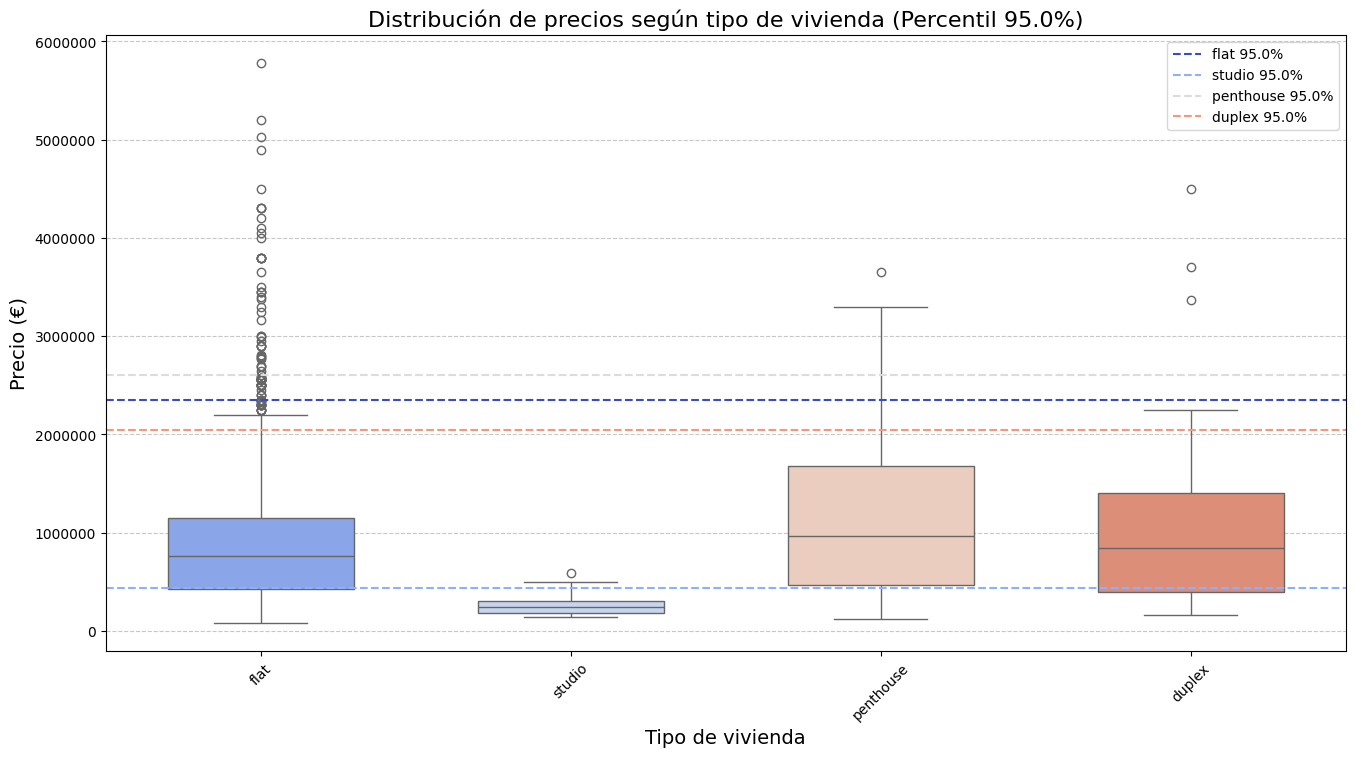

In [110]:
# Definir el percentil como variable (por ejemplo, 95% = 0.95)
percentil = 0.95

# Calcular el percentil para cada tipo de propiedad
percentil_valores = df4.groupby('tipo')['price'].quantile(percentil)

# Mostrar los percentiles calculados
print(f"Percentiles al {percentil*100}%:")
print(percentil_valores)

# Calcular el total de datos por tipo de propiedad
total_datos_por_tipo = df4.groupby('tipo').size()

# Calcular el número de datos que están por debajo del percentil para cada tipo de propiedad
datos_percentil = df4[df4['price'] <= df4['tipo'].map(percentil_valores)].groupby('tipo').size()

# Calcular los datos eliminados (total - datos dentro del percentil)
datos_eliminados = total_datos_por_tipo - datos_percentil

# Imprimir la información solicitada
for prop_type in df4['tipo'].unique():
    print(f"\nTipo de vivienda: {prop_type}")
    print(f"Precio percentil {percentil*100}%: {percentil_valores[prop_type]:,.2f}€")
    print(f"Número total de datos iniciales: {total_datos_por_tipo[prop_type]}")
    print(f"Número total de datos en el percentil {percentil*100}%: {datos_percentil[prop_type]}")
    print(f"Número de datos eliminados: {datos_eliminados[prop_type]}")

# Crear el gráfico de boxplot
plt.figure(figsize=(16, 8))  # Gráfico más grande para evitar achatamiento

# Boxplot
sns.boxplot(data=df4, x='tipo', y='price', hue= 'tipo', palette='coolwarm', width=0.6)

# Agregar las líneas horizontales de los percentiles para cada tipo de propiedad
for i, prop_type in enumerate(df4['tipo'].unique()):
    color = plt.cm.coolwarm(i / len(df4['tipo'].unique()))  # Tomar un color de la paleta
    plt.axhline(percentil_valores[prop_type], color=color, linestyle='--', 
                label=f'{prop_type} {percentil*100}%')
    
# Ajustes estéticos
plt.title(f'Distribución de precios según tipo de vivienda (Percentil {percentil*100}%)', fontsize=16)
plt.xlabel('Tipo de vivienda', fontsize=14)
plt.ylabel('Precio (€)', fontsize=14)
plt.xticks(rotation=45)  # Rotar etiquetas si es necesario

# Evitar notación científica en el eje Y
plt.ticklabel_format(style='plain', axis='y')

# Agregar una cuadrícula horizontal para mejor referencia
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Leyenda
plt.legend()

# Guardar imagen
plt.savefig(f'graf/boxplot_vivienda_precio_percentil{percentil*100}.png', dpi=150, bbox_inches='tight')

# Mostrar gráfico
plt.show()


Filtrar por los extremos del boxplot es más adaptado, y es más riguroso. Una vez visto el gráfico anterior, prefiero este sistema, preferible en contextos de análisis inmobiliarios, para evitar distorsionar el modelo con propiedades de lujo o de valor bajo por condiciones singulares (usufructos, expropiaciones, subastas, etc)

Tipo: flat, Límite inferior: -1025000.0, Límite superior: 2600000.0, Número total de datos inicial: 1458, Número total de datos dentro de los bigotes: 1414, Número de datos eliminados: 44
Tipo: studio, Límite inferior: -81000.0, Límite superior: 565250.0, Número total de datos inicial: 71, Número total de datos dentro de los bigotes: 70, Número de datos eliminados: 1
Tipo: penthouse, Límite inferior: -1961000.0, Límite superior: 4099000.0, Número total de datos inicial: 118, Número total de datos dentro de los bigotes: 118, Número de datos eliminados: 0
Tipo: duplex, Límite inferior: -1610000.0, Límite superior: 3415000.0, Número total de datos inicial: 72, Número total de datos dentro de los bigotes: 70, Número de datos eliminados: 2


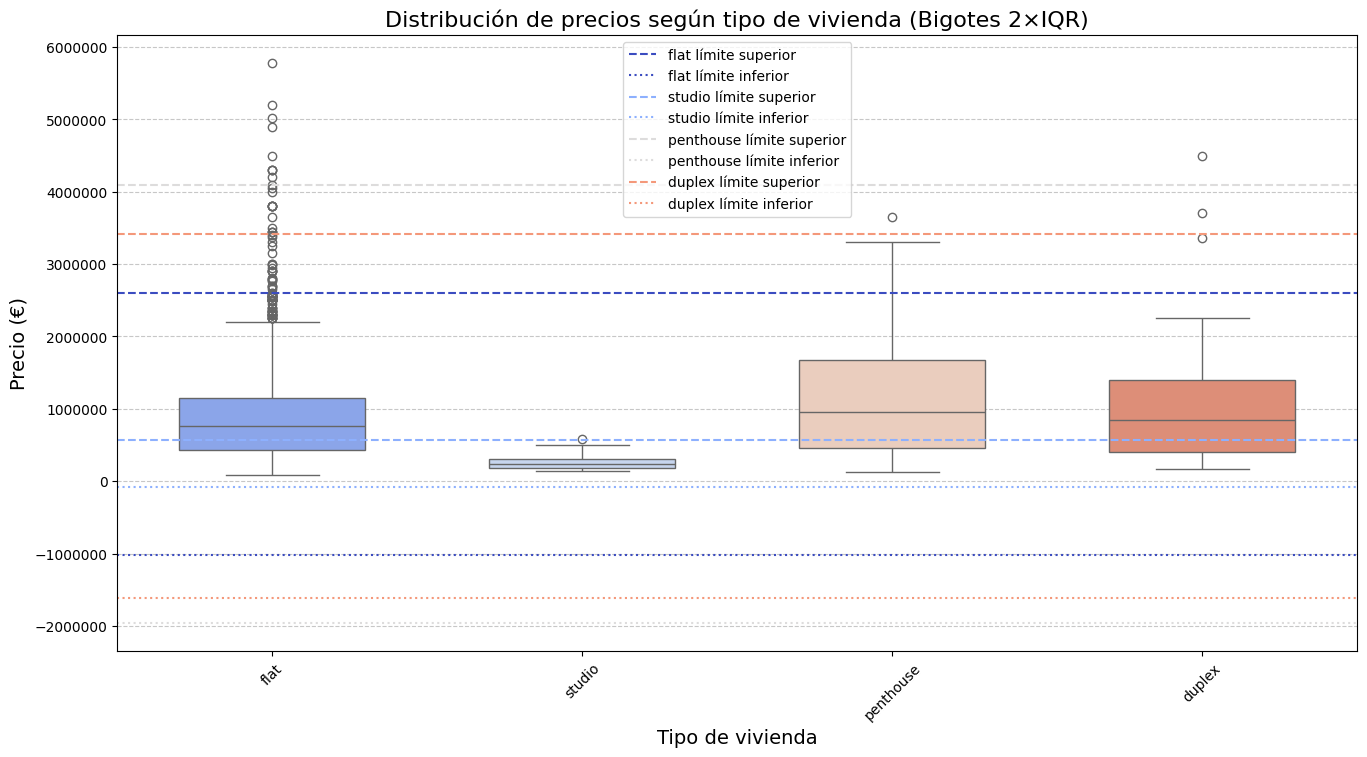

In [111]:
# Selección de outliers por criterio de bigotes.
# Definir el factor de IQR como variable
factor_iqr = 2  # Puedes cambiar este valor según lo necesites

# Calcular los límites de los bigotes del boxplot para cada tipo de propiedad
iqr_limits = {}

for prop_type in df4['tipo'].unique():
    q1 = np.percentile(df4[df4['tipo'] == prop_type]['price'], 25)
    q3 = np.percentile(df4[df4['tipo'] == prop_type]['price'], 75)
    iqr = q3 - q1
    lower_bound = q1 - factor_iqr * iqr
    upper_bound = q3 + factor_iqr * iqr
    iqr_limits[prop_type] = (lower_bound, upper_bound)

# Imprimir el resumen de datos
for prop_type in df4['tipo'].unique():
    lower_bound, upper_bound = iqr_limits[prop_type]
    total_datos_inicial = len(df4[df4['tipo'] == prop_type])
    total_datos_filtrados = len(df4[(df4['tipo'] == prop_type) & 
                                    (df4['price'] >= lower_bound) & 
                                    (df4['price'] <= upper_bound)])
    datos_eliminados = total_datos_inicial - total_datos_filtrados

    print(f"Tipo: {prop_type}, "
          f"Límite inferior: {lower_bound}, "
          f"Límite superior: {upper_bound}, "
          f"Número total de datos inicial: {total_datos_inicial}, "
          f"Número total de datos dentro de los bigotes: {total_datos_filtrados}, "
          f"Número de datos eliminados: {datos_eliminados}")

# Crear el gráfico de boxplot
plt.figure(figsize=(16, 8))  # Gráfico más grande para evitar achatamiento

# Dibujar el boxplot
sns.boxplot(data=df4, x='tipo', y='price', hue='tipo', palette='coolwarm', width=0.6)

# Agregar las líneas horizontales de los bigotes para cada tipo de propiedad
for i, prop_type in enumerate(df4['tipo'].unique()):
    lower_bound, upper_bound = iqr_limits[prop_type]
    color = plt.cm.coolwarm(i / len(df4['tipo'].unique()))  # Tomar un color de la paleta
    plt.axhline(upper_bound, color=color, linestyle='--', label=f'{prop_type} límite superior')
    plt.axhline(lower_bound, color=color, linestyle=':', label=f'{prop_type} límite inferior')

# Ajustes estéticos
plt.title(f'Distribución de precios según tipo de vivienda (Bigotes {factor_iqr}×IQR)', fontsize=16)
plt.xlabel('Tipo de vivienda', fontsize=14)
plt.ylabel('Precio (€)', fontsize=14)
plt.xticks(rotation=45)  # Rotar etiquetas si es necesario

# Evitar notación científica en el eje Y
plt.ticklabel_format(style='plain', axis='y')

# Agregar una cuadrícula horizontal para mejor referencia
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Leyenda
plt.legend()

# Guardar imagen
plt.savefig(f'graf/boxplot_vivienda_precio_IQR{factor_iqr}.png', dpi=150, bbox_inches='tight')

# Mostrar gráfico
plt.show()



Voy a automatizar la eliminación de outliers mediante una función, donde puedo elegir el método y el valor de corte.

In [112]:
# Función fitrado outliers 
def eliminar_outliers(df, metodo=None, bigotes=1.5, percentil=0.95):
    """
    Filtra outliers de un DataFrame según el método seleccionado.
    
    Parámetros:
    - df (pd.DataFrame): DataFrame de entrada (se copia para no modificar el original).
    - metodo (str): 'bigotes' para usar el método IQR o 'percentil' para usar percentiles.
    - bigotes (float, opcional): Factor multiplicador de IQR para definir los bigotes (default = 1.5).
    - percentil (float, opcional): Percentil para el umbral de eliminación (default = 0.95).
    
    Retorna:
    - pd.DataFrame: Nuevo DataFrame sin los outliers según el método elegido.
    """
    # Copia del DataFrame original
    df_filtrado = df.copy()

    # Verificar si la columna 'tipo' existe
    if 'tipo' not in df.columns or 'price' not in df.columns:
        print("Error: El DataFrame debe contener las columnas 'tipo' y 'price'.")
        return None

    # Si no se ha pasado ningún método, pedirlo
    if metodo not in ['bigotes', 'percentil']:
        print("Debe especificar un método de filtrado: 'bigotes' o 'percentil'.")
        return None

    if metodo == 'bigotes':
        print(f"Filtrando con método 'bigotes' (IQR * {bigotes})...")

        # Calcular los límites de los bigotes para cada tipo de propiedad
        for prop_type in df_filtrado['tipo'].unique():
            subset = df_filtrado[df_filtrado['tipo'] == prop_type]['price']
            q1, q3 = np.percentile(subset, [25, 75])
            iqr = q3 - q1
            lower_bound = q1 - bigotes * iqr
            upper_bound = q3 + bigotes * iqr

            # Filtrar el DataFrame
            df_filtrado = df_filtrado[
                ~((df_filtrado['tipo'] == prop_type) & 
                  ((df_filtrado['price'] < lower_bound) | (df_filtrado['price'] > upper_bound)))
            ]

    elif metodo == 'percentil':
        print(f"Filtrando con método 'percentil' ({percentil*100}%)...")

        # Calcular el percentil seleccionado para cada tipo de propiedad
        percentiles = df_filtrado.groupby('tipo')['price'].quantile(percentil)

        # Filtrar el DataFrame
        df_filtrado = df_filtrado[
            df_filtrado.apply(lambda row: row['price'] <= percentiles[row['tipo']], axis=1)
        ]

    # Mostrar resumen de filtrado
    for prop_type in df['tipo'].unique():
        total_datos_inicial = len(df[df['tipo'] == prop_type])
        total_datos_filtrados = len(df_filtrado[df_filtrado['tipo'] == prop_type])
        datos_eliminados = total_datos_inicial - total_datos_filtrados

        print(f"Tipo: {prop_type}, "
              f"Número total de datos inicial: {total_datos_inicial}, "
              f"Número total de datos filtrados: {total_datos_filtrados}, "
              f"Número de datos eliminados: {datos_eliminados}")

    return df_filtrado


In [113]:
df4.head()

price  terraza  numPhotos  floor    tipo   size  exterior  \
ID                                                                         
107526421  1095000.0        0         43    3.0    flat  146.0         1   
107246640  1195000.0        0         27    2.0    flat  134.0         1   
106773918   790000.0        0         33    3.0    flat  148.0         1   
102711209  2350000.0        1         44    5.0    flat  218.0         1   
106822977   235000.0        0         34    0.0  studio   38.0         0   

           rooms  bathrooms  hasVideo  ...  barrio_Chueca-Justicia  \
ID                                     ...                           
107526421      3          2         1  ...                       0   
107246640      3          3         1  ...                       0   
106773918      2          2         1  ...                       0   
102711209      4          4         1  ...                       0   
106822977      0          1         1  ...                       0   

           barrio_Huertas-Cortes  barrio_Lavapiés-Embajadores  \
ID                                                              
107526421                      0                            0   
107246640                      0                            0   
106773918                      0                            1   
102711209                      0                            0   
106822977                      0                            0   

           barrio_Malasaña-Universidad  barrio_Palacio  barrio_Sol  tipo_flat  \
ID                                                                              
107526421                            0               0           1          1   
107246640                            1               0           0          1   
106773918                            0               0           0          1   
102711209                            0               0           1          1   
106822977                            1               0           0          0   

           tipo_studio  tipo_penthouse  tipo_duplex  
ID                                                   
107526421            0               0            0  
107246640            0               0            0  
106773918            0               0            0  
102711209            0               0            0  
106822977            1               0            0  

[5 rows x 26 columns]

In [114]:
print(df4.shape)
df4.columns.tolist

(1719, 26)


<bound method IndexOpsMixin.tolist of Index(['price', 'terraza', 'numPhotos', 'floor', 'tipo', 'size', 'exterior',
       'rooms', 'bathrooms', 'hasVideo', 'status', 'hasLift', 'hasPlan',
       'has3DTour', 'has360', 'topPlus', 'barrio_Chueca-Justicia',
       'barrio_Huertas-Cortes', 'barrio_Lavapiés-Embajadores',
       'barrio_Malasaña-Universidad', 'barrio_Palacio', 'barrio_Sol',
       'tipo_flat', 'tipo_studio', 'tipo_penthouse', 'tipo_duplex'],
      dtype='object')>

In [115]:
df5 = eliminar_outliers(df4, metodo='bigotes', bigotes = 2)

Filtrando con método 'bigotes' (IQR * 2)...
Tipo: flat, Número total de datos inicial: 1458, Número total de datos filtrados: 1414, Número de datos eliminados: 44
Tipo: studio, Número total de datos inicial: 71, Número total de datos filtrados: 70, Número de datos eliminados: 1
Tipo: penthouse, Número total de datos inicial: 118, Número total de datos filtrados: 118, Número de datos eliminados: 0
Tipo: duplex, Número total de datos inicial: 72, Número total de datos filtrados: 70, Número de datos eliminados: 2


In [116]:
df5.shape

(1672, 26)

Eliminamos la columna 'tipo' que mantuvimos para clasificar outliers por grupos

In [117]:
#eliminar la columna tipo en ambos dataframe df4, df5 a guardar para ML
if 'tipo' in df4.columns:
    df4.drop('tipo', axis=1, inplace=True, errors = 'ignore')
else:
    print("⚠️ Advertencia: La columna 'tipo' YA no existe en df4.")

if 'tipo' in df5.columns:
    df5.drop('tipo', axis=1, inplace=True, errors = 'ignore')
else:
    print("⚠️ Advertencia: La columna 'tipo' YA no existe en df5.")

In [118]:
# Datos nombrado archivo.
today =  date.today ()
file_path = f'../data/processed/ide_viv_numerico1(df4)_{today}.csv' 

#Guardo df4 como dataframe solo numérico para ML sin reducción de outliers
df_to_csv (df4)

✅ Archivo guardado correctamente como '../data/processed/ide_viv_numerico1(df4)_2025-03-20.csv'.


In [119]:
# Datos nombrado archivo.
today =  date.today ()
file_path = f'../data/processed/ide_viv_numerico2(df5)_{today}.csv' 

#Guardo df4 como dataframe solo numérico para ML eliminados outliers
df_to_csv (df5)

✅ Archivo guardado correctamente como '../data/processed/ide_viv_numerico2(df5)_2025-03-20.csv'.


[Ir al inicio de la sección 12 ](#outliers)

<a id="feat-engi"></a>
<a href="#inicio-notebook"><p style="text-align:right;" href="#inicio-notebook">Volver al índice</p></a> 
## 13. Feature Engineering

Aplicación de la transformación logarítmica (probada en el notebook anterior) a la target

Con ambos dataframe, df4 y df5, con y sin outliers, realizo una transformación logarítmica SOLAMENTE en la target, 'price', y los reservo para aplicar diferentes metodos de reduccion de dimensionalidad en el punto siguiente. 

In [120]:
df4_log = df4.copy()  # Crear una copia del DataFrame original
df4_log['price'] = np.log(df4_log['price'])  # Aplicar la transformación logarítmica solo en la copia
df4_log.rename(columns={'price': 'priceLog'}, inplace=True)


In [121]:
print(df4_log.shape)
df4_log.head(2)

(1719, 25)


priceLog  terraza  numPhotos  floor   size  exterior  rooms  \
ID                                                                        
107526421  13.906265        0         43    3.0  146.0         1      3   
107246640  13.993657        0         27    2.0  134.0         1      3   

           bathrooms  hasVideo  status  ...  barrio_Chueca-Justicia  \
ID                                      ...                           
107526421          2         1       1  ...                       0   
107246640          3         1       1  ...                       0   

           barrio_Huertas-Cortes  barrio_Lavapiés-Embajadores  \
ID                                                              
107526421                      0                            0   
107246640                      0                            0   

           barrio_Malasaña-Universidad  barrio_Palacio  barrio_Sol  tipo_flat  \
ID                                                                              
107526421                            0               0           1          1   
107246640                            1               0           0          1   

           tipo_studio  tipo_penthouse  tipo_duplex  
ID                                                   
107526421            0               0            0  
107246640            0               0            0  

[2 rows x 25 columns]

In [122]:
df5_log = df5.copy()  # Crear una copia del DataFrame original
df5_log['price'] = np.log(df5_log['price'])  # Aplicar la transformación logarítmica solo en la copia
df5_log.rename(columns={'price': 'priceLog'}, inplace=True)

In [123]:
df5_log.shape   #sin outliers

(1672, 25)

(por ejemplo con df5_log, prueba de modelo sencillo Dummy copiado del notebook siguiente)

In [124]:
# Modelo Dummy tanteo
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

X = df5_log.drop(['priceLog'], axis=1)  # Eliminamos la variable objetivo
y = df5_log['priceLog']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

# Predicción en la escala logarítmica
y_pred_dummy_log = dummy.predict(X_val)

# Transformar los valores a la escala original
y_val_original = np.expm1(y_val)  # Revertir log(price)
y_pred_dummy_original = np.expm1(y_pred_dummy_log)

# Evaluación con RMSE en la escala original
rmse_dummy = np.sqrt(mean_squared_error(y_val_original, y_pred_dummy_original))
print(f"RMSE (escala original): {rmse_dummy:,.2f} €")

# Evaluación con MAPE en la escala original
mape_dummy = mean_absolute_percentage_error(y_val_original, y_pred_dummy_original) * 100
print(f"MAPE (escala original): {mape_dummy:.2f} %")

RMSE (escala original): 605,902.56 €
MAPE (escala original): 70.06 %


Comprobado que los resultados que obtengo sin normalizar y/o estandarizar las diferentes variables es muy malo, realizo dichas transformaciones:

Crearé funciones para transformar logarítmicamante las variables que considero lo necesitan, y otra para normalizar todas aquellas variables que lo requieren.

In [125]:
# Función aplicar logaritmo a roooms, bathrooms, numPhotos, size. 
def trans_log(dataframe):
    """
    Aplica la transformación logarítmica a una lista predefinida de columnas en un DataFrame.
    
    Parámetros:
    - dataframe: pd.DataFrame -> DataFrame original
    
    Retorna:
    - DataFrame con las columnas transformadas
    """
    df = dataframe.copy()  # Hacemos una copia para no modificar el original
    
    # Lista de columnas a transformar
    columns = ["rooms", "bathrooms", "numPhotos", "size"]
    
    for col in columns:
        if col in df.columns:
            # Verificar si la columna ya ha sido transformada (si todos los valores son menores a 1, probablemente ya lo estén)
            if (df[col] <= 1).all():
                print(f"⚠️ Advertencia: La columna '{col}' ya parece estar transformada. Se omite la transformación.")
                continue  # Pasamos a la siguiente columna
            
            df[col] = np.log1p(df[col])  # log1p(x) = log(1 + x), evita problemas con ceros
        else:
            print(f"⚠️ Advertencia: La columna '{col}' no existe en el DataFrame.")
    
    return df

In [126]:
#df_transformed = trans_log(df)

In [127]:
# # NO USAR Función aplicar Min-Max Scaler sin previa separación fit a solo train 
# def reescala(dataframe, scaler='standard'):
#     """
#     Aplica la estandarización o normalización a una lista predefinida de columnas en un DataFrame.
    
#     Parámetros:
#     - dataframe: pd.DataFrame -> DataFrame original
#     - scaler: str -> Tipo de escalado ('standard' para StandardScaler, 'minmax' para MinMaxScaler)
    
#     Retorna:
#     - DataFrame con las columnas transformadas
#     """
#     df = dataframe.copy()  # Hacemos una copia para no modificar el original
    
#     # Lista de columnas a escalar
#     columns = ["rooms", "bathrooms", "numPhotos", "size"]

#     # Selección del método de escalado
#     if scaler == 'standard':
#         scaler_instance = StandardScaler()
#     elif scaler == 'minmax':
#         scaler_instance = MinMaxScaler()
#     else:
#         raise ValueError("El parámetro 'scaler' debe ser 'standard' o 'minmax'.")

#     for col in columns:
#         if col in df.columns:
#             # Verificar si la columna ya ha sido transformada
#             col_mean = df[col].mean()
#             col_std = df[col].std()

#             # Se considera que una columna ya está normalizada si su media está cercana a 0 y su desviación cercana a 1
#             if scaler == 'standard' and (np.isclose(col_mean, 0, atol=0.1) and np.isclose(col_std, 1, atol=0.1)):
#                 print(f"⚠️ Advertencia: La columna '{col}' ya parece estar estandarizada. Se omite la transformación.")
#                 continue
            
#             # Se considera que una columna ya está normalizada con MinMax si sus valores están entre 0 y 1
#             if scaler == 'minmax' and (df[col].min() >= 0 and df[col].max() <= 1):
#                 print(f"⚠️ Advertencia: La columna '{col}' ya parece estar normalizada con MinMax. Se omite la transformación.")
#                 continue

#             # Aplicar la transformación
#             df[col] = scaler_instance.fit_transform(df[[col]])  # Necesita array bidimensional
#         else:
#             print(f"⚠️ Advertencia: La columna '{col}' no existe en el DataFrame.")

#     return df

In [128]:
# Función aplicar Min-Max Scaler a rooms, bathrooms, numPhotos, size
def reescala(dataframe, scaler='standard', test_size=0.2, random_state=42):
    """
    Aplica la estandarización o normalización a una lista predefinida de columnas en un DataFrame.
    La función separa internamente en Train/Test antes de escalar.

    Parámetros:
    - dataframe: pd.DataFrame -> DataFrame original con todas las columnas (debe incluir 'target', 'price' o 'priceLog').
    - scaler: str -> Tipo de escalado ('standard' para StandardScaler, 'minmax' para MinMaxScaler).
    - test_size: float -> Proporción del conjunto de prueba en la división (default 0.2).
    - random_state: int -> Semilla para la reproducibilidad.

    Retorna:
    - DataFrame con las columnas transformadas (manteniendo la estructura original).
    """
    df = dataframe.copy()  # Copia del DataFrame original

    # Verificar qué nombre tiene la variable objetivo
    target_names = ['target', 'price', 'priceLog']
    target_col = next((col for col in target_names if col in df.columns), None)

    if target_col is None:
        raise ValueError("❌ ERROR: La target no está en este DataFrame. Asegúrate de incluir 'target', 'price' o 'priceLog'.")

    # Separar X (features) e y (target)
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Separar en Train/Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Lista de columnas a escalar
    columns = ["rooms", "bathrooms", "numPhotos", "size"]

    # Selección del método de escalado
    if scaler == 'standard':
        scaler_instance = StandardScaler()
    elif scaler == 'minmax':
        scaler_instance = MinMaxScaler()
    else:
        raise ValueError("❌ ERROR: El parámetro 'scaler' debe ser 'standard' o 'minmax'.")

    for col in columns:
        if col in X_train.columns:
            # Verificar si la columna ya está escalada
            col_mean = X_train[col].mean()
            col_std = X_train[col].std()

            if scaler == 'standard' and (np.isclose(col_mean, 0, atol=0.1) and np.isclose(col_std, 1, atol=0.1)):
                print(f"⚠️ Advertencia: La columna '{col}' ya parece estar estandarizada. Se omite la transformación.")
                continue

            if scaler == 'minmax' and (X_train[col].min() >= 0 and X_train[col].max() <= 1):
                print(f"⚠️ Advertencia: La columna '{col}' ya parece estar normalizada con MinMax. Se omite la transformación.")
                continue

            # Ajustar el escalador solo con X_train
            scaler_instance.fit(X_train[[col]])

            # Aplicar la transformación a X_train y X_test
            X_train[col] = scaler_instance.transform(X_train[[col]])
            X_test[col] = scaler_instance.transform(X_test[[col]])

        else:
            print(f"⚠️ Advertencia: La columna '{col}' no existe en el DataFrame.")

    # Reconstruir DataFrame uniendo los conjuntos escalados
    df_scaled_train = X_train.copy()
    df_scaled_train[target_col] = y_train

    df_scaled_test = X_test.copy()
    df_scaled_test[target_col] = y_test

    df = pd.concat([df_scaled_train, df_scaled_test])

    return df


In [129]:
# Ejemplo de uso
#df_scaled = reescala(df, scaler='minmax')  # O 'standard'

In [161]:
df_transformed = trans_log(df4_log)
df4_final = reescala(df_transformed, scaler='minmax') 

In [ ]:
# Datos nombrado archivo.
today =  date.today ()
file_path = f'../data/processed/ide_viv_num1_tf_es_{today}.csv' 

#Guardo dataframe numérico transformado y escalado, procedente de df4 como dataframe para ML sin reducción de outliers
df_to_csv (df4_final)

✅ Archivo guardado correctamente como '../data/processed/ide_viv_num1_tf_es_2025-03-20.csv'.


In [162]:
df_transformed = trans_log(df5_log)
df5_final = reescala(df_transformed, scaler='minmax') 

In [ ]:
# Datos nombrado archivo.
today =  date.today ()
file_path = f'../data/processed/ide_viv_num2_tf_es_{today}.csv' 

#Guardo dataframe numérico transformado y escalado, procedente de df5 para ML eliminados outliers
df_to_csv (df5_final)

✅ Archivo guardado correctamente como '../data/processed/ide_viv_num2_tf_es_2025-03-20.csv'.


## 14. Reducción de dimensionalidad (asistidos)
(basada en procesos automáticos)

Por último probamos antes de pasar a la división de train y validation, feature reduction.

In [134]:
# Preparación datos para selección de características: separación de la target
X = df5_log.drop(['priceLog'], axis=1)  # Eliminamos la variable objetivo y variables no útiles
y = df5_log['priceLog']

X.shape

(1672, 24)

Usaré las funciones creadas anteriormente de transformación logarítmica y estandarización para usar con cada uno de los métodos de reducción de dimensionalidad según lo precisen.

**Métodos de reducción de dimensionalidad**

In [135]:
# Método 1: Correlación con la variable objetivo
#aplico antes la transformación para normalizar y el reescalado.
df_transformed = trans_log(df5_log)
df_scaled = reescala(df_transformed, scaler='minmax') 

#Preparar mi dataframe transformado logaritmo y reescalado para la selección de características:
X = df_scaled.drop(['priceLog'], axis=1)  # Eliminamos la variable objetivo y variables no útiles
y = df_scaled['priceLog']

correlaciones = X.corrwith(y).abs().sort_values(ascending=False)
print("\nCorrelación de las características con precio:")
print(correlaciones.head(12))


Correlación de las características con precio:
size                           0.891394
bathrooms                      0.745479
rooms                          0.644482
exterior                       0.518988
barrio_Lavapiés-Embajadores    0.448678
hasLift                        0.409492
tipo_studio                    0.305879
barrio_Chueca-Justicia         0.289005
floor                          0.217296
terraza                        0.173620
barrio_Sol                     0.143921
barrio_Huertas-Cortes          0.136514
dtype: float64


In [136]:
# Método 2: SelectKBest con f_regression
#aplico antes la transformación para normalizar (NO necesario el reescalado)
df_transformed = trans_log(df5_log)

#Preparar mi dataframe transformado logaritmo para la selección de características:
X = df_transformed.drop(['priceLog'], axis=1)  # Eliminamos la variable objetivo y variables no útiles
y = df_transformed['priceLog']

selector = SelectKBest(score_func=f_regression, k=10)
X_selector = selector.fit_transform(X, y)
mask = selector.get_support()
caracteristicas_seleccionadas = X.columns[mask]

print("\nCaracterísticas seleccionadas con SelectKBest:")
print(caracteristicas_seleccionadas.tolist)


Características seleccionadas con SelectKBest:
<bound method IndexOpsMixin.tolist of Index(['terraza', 'floor', 'size', 'exterior', 'rooms', 'bathrooms', 'hasLift',
       'barrio_Chueca-Justicia', 'barrio_Lavapiés-Embajadores', 'tipo_studio'],
      dtype='object')>


Importancia de características con Random Forest:
size                           0.819972
floor                          0.036719
bathrooms                      0.025342
barrio_Lavapiés-Embajadores    0.024304
numPhotos                      0.023619
hasLift                        0.009318
rooms                          0.008855
status                         0.007831
barrio_Chueca-Justicia         0.005778
exterior                       0.005227
dtype: float64


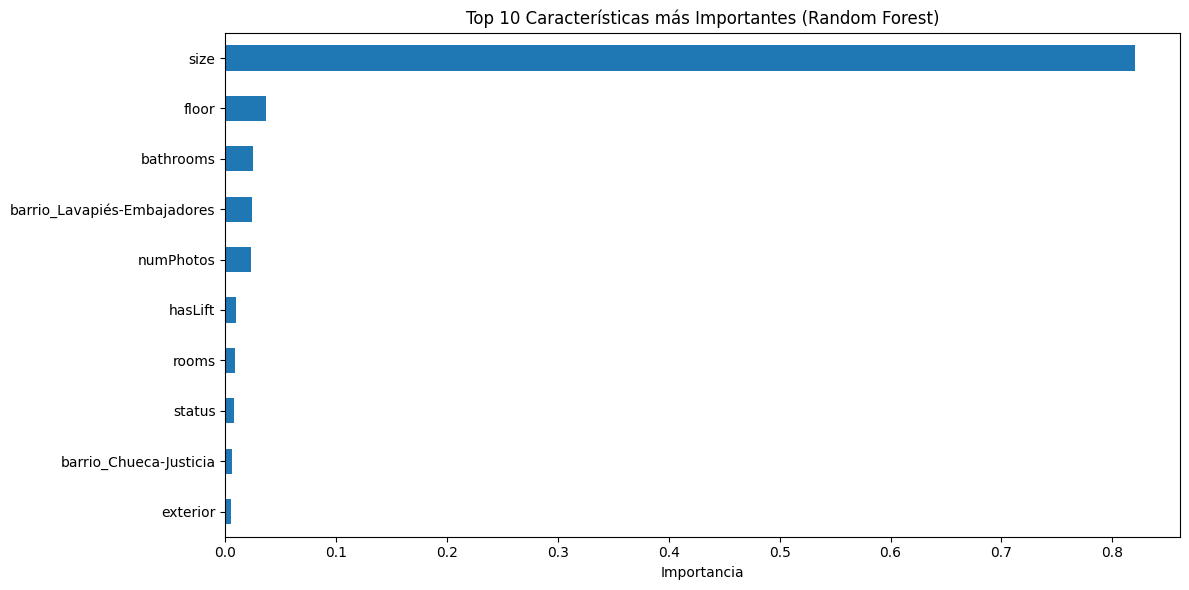

In [137]:
# Método 3: Importancia de características con Random Forest
# en este caso,RF  usa todas las variables, y estas compiten entre si para ver las más importantes 
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importancias = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("Importancia de características con Random Forest:")
print(importancias.head(10))

plt.figure(figsize=(12, 6))
importancias.head(10).plot(kind='barh')
plt.title('Top 10 Características más Importantes (Random Forest)')
plt.xlabel('Importancia')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar la más importante arriba
plt.tight_layout()
plt.show()

In [138]:
# REPLICADO Método 3: Importancia de características con Random Forest APLICANDO TRANSFORMACIÓN Y ESCALADO
# en este caso,RF  usa todas las variables, y estas compiten entre si para ver las más importantes 

#aplico antes la transformación para normalizar y el reescalado.
df_transformed = trans_log(df5_log)
df_scaled = reescala(df_transformed, scaler='minmax') 

#Preparar mi dataframe transformado logaritmo y reescalado para la selección de características:
X = df_scaled.drop(['priceLog'], axis=1)  # Eliminamos la variable objetivo y variables no útiles
y = df_scaled['priceLog']

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importancias = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("Importancia de características con Random Forest (previa transf. logarítmica y reescalado):")
print(importancias.head(10))


Importancia de características con Random Forest (previa transf. logarítmica y reescalado):
size                           0.804746
bathrooms                      0.041732
floor                          0.035146
barrio_Lavapiés-Embajadores    0.024613
numPhotos                      0.023633
rooms                          0.009035
hasLift                        0.008999
status                         0.008294
barrio_Chueca-Justicia         0.005800
barrio_Palacio                 0.004851
dtype: float64


In [139]:
# REPLICADO Método 3: Importancia de características con Random Forest APLICANDO SOLO TRANSFORMACIÓN LOGARÍTMICA
# en este caso,RF  usa todas las variables, y estas compiten entre si para ver las más importantes 

#aplico antes la transformación para normalizar
df_transformed = trans_log(df5_log)

#Preparar mi dataframe transformado logaritmo y reescalado para la selección de características:
X = df_transformed.drop(['priceLog'], axis=1)  # Eliminamos la variable objetivo y variables no útiles
y = df_transformed['priceLog']

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importancias = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("Importancia de características con Random Forest (previa transformación logarítmica):")
print(importancias.head(10))

print("Esto es idéntico resultado a no aplicar nada")

Importancia de características con Random Forest (previa transformación logarítmica):
size                           0.819972
floor                          0.036719
bathrooms                      0.025342
barrio_Lavapiés-Embajadores    0.024304
numPhotos                      0.023619
hasLift                        0.009318
rooms                          0.008855
status                         0.007831
barrio_Chueca-Justicia         0.005778
exterior                       0.005227
dtype: float64
Esto es idéntico resultado a no aplicar nada


In [140]:
# REPLICADO Método 3: Importancia de características con Random Forest APLICANDO SOLO ESCALADO
# en este caso,RF  usa todas las variables, y estas compiten entre si para ver las más importantes 

#aplico antes la transformación para el reescalado.
df_scaled = reescala(df5_log, scaler='minmax') 

#Preparar mi dataframe transformado logaritmo y reescalado para la selección de características:
X = df_scaled.drop(['priceLog'], axis=1)  # Eliminamos la variable objetivo y variables no útiles
y = df_scaled['priceLog']

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importancias = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("Importancia de características con Random Forest (previo reescalado):")
print(importancias.head(10))

print("Esto es idéntico resultado a aplicar ambas cosas")

Importancia de características con Random Forest (previo reescalado):
size                           0.804746
bathrooms                      0.041732
floor                          0.035146
barrio_Lavapiés-Embajadores    0.024613
numPhotos                      0.023633
rooms                          0.009035
hasLift                        0.008999
status                         0.008294
barrio_Chueca-Justicia         0.005800
barrio_Palacio                 0.004851
dtype: float64
Esto es idéntico resultado a aplicar ambas cosas


Conclusión de lo anterior, la transformación de logaritmo no hace nada, y el reescalado con Min-Max modificad mínimamente los valores, alterando algun orden de ellos.

Características seleccionadas por RFE:
['numPhotos', 'floor', 'size', 'rooms', 'bathrooms', 'status', 'hasLift', 'barrio_Chueca-Justicia', 'barrio_Lavapiés-Embajadores', 'tipo_penthouse']


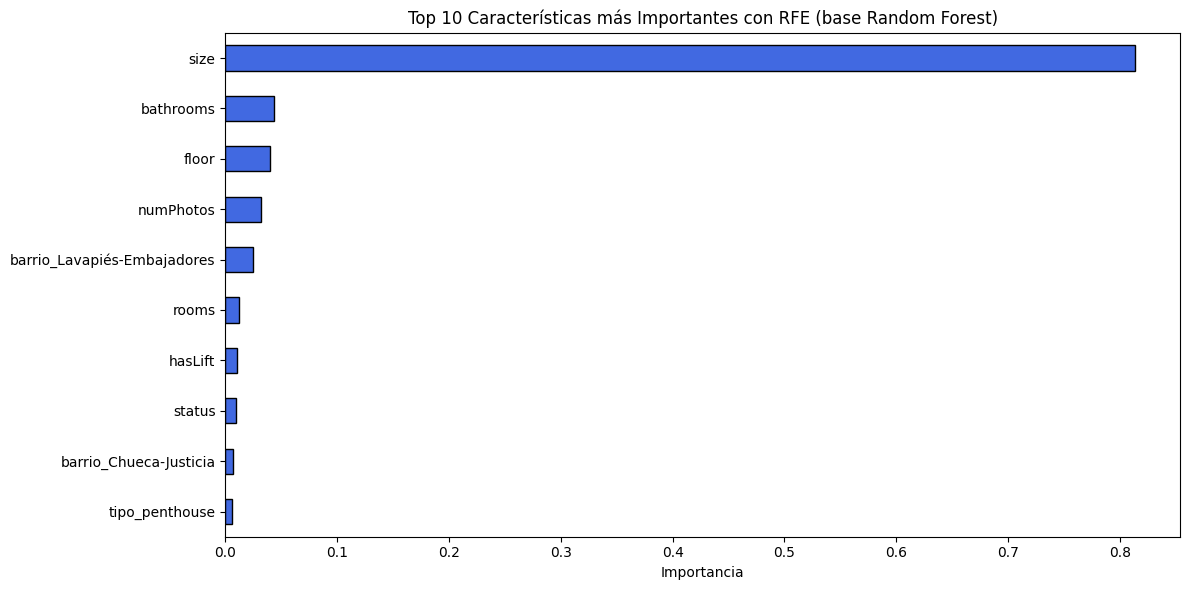

In [141]:
# Método 4: RFE con modelo de Random Forest
# en este caso, usamos RFE para seleccionar la n features más importantes, 
# y descartamos las demás antes de entrenar el modelo RandomForest

model = RandomForestRegressor(random_state=42)
 
# Selección de características con RFE
selector = RFE(model, n_features_to_select=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

# Entrenar el modelo de Random Forest con las características seleccionadas
model.fit(X_selected, y)

# Obtener la importancia de las características seleccionadas
importances = pd.Series(model.feature_importances_, index=selected_features)

# Ordenar de mayor a menor
importances = importances.sort_values(ascending=False)

# Mostrar las características seleccionadas
print("Características seleccionadas por RFE:")
print(selected_features.tolist())

# Gráfico de barras con las 10 más importantes
plt.figure(figsize=(12, 6))
importances.head(10).plot(kind='barh', color='royalblue', edgecolor='black')
plt.title('Top 10 Características más Importantes con RFE (base Random Forest)')
plt.xlabel('Importancia')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar la más importante arriba
plt.tight_layout()
plt.show()

<a id="metrica"></a> 
## 15. Métrica del modelo

Estamos ante un ejercicio de regresión, con lo cual las métricas pueden ser R^2, MSE, RMSE, MAE o  MAPE.

Después de ver sus características, voy a usar RMSE, la Raíz del Error Cuadrático Medio, en la misma unidad que el precio, y el MAPE, Error Absoluto Porcentual Medio. Ambos los voy a transformar con la inversa del logaritmo, para volver a la escala original. 

In [142]:
# from sklearn.metrics import mean_squared_error

# rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f"RMSE (log): {rmse_log}")

# rmse_original = np.exp(rmse_log) - 1
# print(f"RMSE en la escala original: {rmse_original}")

In [143]:
# mape_log = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
# print(f"MAPE (log): {mape_log}%")

# mape_original = np.mean(np.abs((np.exp(y_test) - np.exp(y_pred)) / np.exp(y_test))) * 100
# print(f"MAPE en la escala original: {mape_original}%")


[Ir al inicio del Notebook](#inicio-notebook)

## 16. División en train y test
(resevar una porción de los datos obtenidos para probar nuestros modelos)


In [ ]:
X = df5_final.drop(['priceLog'], axis=1)  # Eliminamos la variable objetivo y variables no útiles
y = df5_final['priceLog']

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba (test): {X_test.shape}")

Tamaño del conjunto de entrenamiento: (1375, 24)
Tamaño del conjunto de prueba (test): (344, 24)


Aquí guardamos en parquet nuestro conjunto train X, y para probarlos en nuestro Baseline con todos nuestros modelos. Desde este momento, test ya se queda aquí reservado para verificar al final con el modelo elegido.

In [ ]:
train_data = X_train.copy()
train_data.insert(0,"priceLog", y_train)  # Inserta la columna objetivo al DataFrame en primer lugar

train_data.shape
#IMPORTANTE, NOMBRE IDENTIFICATIVO DATASET
file_name = 'train_sinOutliers_df5.parquet' #proviene de df5
train_data.to_parquet(f"../data/processed/{file_name}", index=True)


___________________________________________
## XX. Transformaciones a aplicar a test (nuevos datos que vengan)

In [ ]:
#agrupación del código a aplicar a test, que apliqué en train

# Detener la ejecución de esta celda4
# Todo lo que esté aquí no se ejecutará
print("Esta celda está reservada para aplicar a los datos de test.")
return

# # Definir la columna target
target = 'price'  # Reemplaza con el nombre real de la columna target

# Verificar si la columna target está en el DataFrame y eliminarla si existe
if target in datos_test.columns:
    datos_test = datos_test.drop(columns=[target])

# Continuar con el resto del código sin interrupciones
# df.drop_duplicates(keep='first', inplace=True)    #no es necesario eliminar duplicados en el test



df = datos_test.reset_index(drop=True).set_index("propertyCode")
df.index.name = 'ID'

col_eliminar = ['thumbnail','externalReference', 'priceInfo', 'operation', 'province', 'municipality',
       'country', 'showAddress', 'url', 'newDevelopment', 'change', 'highlight', 'savedAd', 
       'notes','hasStaging', 'topNewDevelopment', 'parkingSpace' ,'newDevelopmentFinished', 'priceByArea']
df.drop(col_eliminar, axis=1, inplace=True)

df = expand_dict_columns(df)

imputar_ascensor(df)






df4.drop('tipo', axis=1, inplace=True, errors = 'ignore')
df5.drop('tipo', axis=1, inplace=True, errors = 'ignore')